# ICS435 Final Project Aggregate Code - Predicting Podcast Listening Times
# By: Christian Dela Cruz, Kyler Okuma, Sean Flynn

# Christian's Linear Regression, MLP, and Ensemble Models

# Imports

In [177]:
#imports
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from pandas.plotting import parallel_coordinates

import lightgbm as lgb
from lightgbm import early_stopping, log_evaluation

from catboost import CatBoostRegressor, Pool

import xgboost as xgb

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import optuna
from skopt import BayesSearchCV
from skopt.space import Categorical

# Load in and explore data

In [6]:
#load in and explore data

#load train and test datasets
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

#define  target column
target_column = 'Listening_Time_minutes'

#shape of datasets
print("Train shape:", train.shape)
print("Test shape:", test.shape)

print("\nTrain columns:", train.columns.tolist())

#missing value check
print("\nMissing values in train:\n", train.isnull().sum())

train.head()


Train shape: (750000, 12)
Test shape: (250000, 11)

Train columns: ['id', 'Podcast_Name', 'Episode_Title', 'Episode_Length_minutes', 'Genre', 'Host_Popularity_percentage', 'Publication_Day', 'Publication_Time', 'Guest_Popularity_percentage', 'Number_of_Ads', 'Episode_Sentiment', 'Listening_Time_minutes']

Missing values in train:
 id                                  0
Podcast_Name                        0
Episode_Title                       0
Episode_Length_minutes          87093
Genre                               0
Host_Popularity_percentage          0
Publication_Day                     0
Publication_Time                    0
Guest_Popularity_percentage    146030
Number_of_Ads                       1
Episode_Sentiment                   0
Listening_Time_minutes              0
dtype: int64


,id,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes
0,0,Mystery Matters,Episode 98,NaN,True Crime,74.81,Thursday,Night,NaN,0.0,Positive,31.41998
1,1,Joke Junction,Episode 26,119.80,Comedy,66.95,Saturday,Afternoon,75.95,2.0,Negative,88.01241
2,2,Study Sessions,Episode 16,73.90,Education,69.97,Tuesday,Evening,8.97,0.0,Negative,44.92531
3,3,Digital Digest,Episode 45,67.17,Technology,57.22,Monday,Morning,78.70,2.0,Positive,46.27824
4,4,Mind & Body,Episode 86,110.51,Health,80.07,Monday,Afternoon,58.68,3.0,Neutral,75.61031


# Fill In Missing Values

In [7]:
#fill missing values
for col in ['Episode_Length_minutes', 'Guest_Popularity_percentage', 'Number_of_Ads']:
    median_value = train[col].median()
    train[col] = train[col].fillna(median_value)
    test[col] = test[col].fillna(median_value)

In [8]:
#missing value check after filling
print("\nMissing values in train:\n", train.isnull().sum())

train.head()


Missing values in train:
 id                             0
Podcast_Name                   0
Episode_Title                  0
Episode_Length_minutes         0
Genre                          0
Host_Popularity_percentage     0
Publication_Day                0
Publication_Time               0
Guest_Popularity_percentage    0
Number_of_Ads                  0
Episode_Sentiment              0
Listening_Time_minutes         0
dtype: int64


,id,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes
0,0,Mystery Matters,Episode 98,63.84,True Crime,74.81,Thursday,Night,53.58,0.0,Positive,31.41998
1,1,Joke Junction,Episode 26,119.80,Comedy,66.95,Saturday,Afternoon,75.95,2.0,Negative,88.01241
2,2,Study Sessions,Episode 16,73.90,Education,69.97,Tuesday,Evening,8.97,0.0,Negative,44.92531
3,3,Digital Digest,Episode 45,67.17,Technology,57.22,Monday,Morning,78.70,2.0,Positive,46.27824
4,4,Mind & Body,Episode 86,110.51,Health,80.07,Monday,Afternoon,58.68,3.0,Neutral,75.61031


# Feature Engineering

In [9]:
#feature engineering (for FE version only)

#feature 1: IsWeekend (1 if Saturday or Sunday, else 0)
def is_weekend(day):
    return int(day in ['Saturday', 'Sunday'])

train['IsWeekend'] = train['Publication_Day'].apply(is_weekend)
test['IsWeekend'] = test['Publication_Day'].apply(is_weekend)

#feature 2: episode length category (short/medium/long)
def episode_length_category(length):
    if pd.isna(length):
        return 'Unknown'
    if length < 30:
        return 'Short'
    elif length < 60:
        return 'Medium'
    else:
        return 'Long'

train['Episode_Length_Category'] = train['Episode_Length_minutes'].apply(episode_length_category)
test['Episode_Length_Category'] = test['Episode_Length_minutes'].apply(episode_length_category)

#feature 3: host vs guest popularity difference
train['Host_vs_Guest_Popularity_Diff'] = train['Host_Popularity_percentage'] - train['Guest_Popularity_percentage']
test['Host_vs_Guest_Popularity_Diff'] = test['Host_Popularity_percentage'] - test['Guest_Popularity_percentage']

#feature 4: ads per minute (avoid divide-by-zero)
train['Ads_Per_Minute'] = train['Number_of_Ads'] / (train['Episode_Length_minutes'] + 1e-5)
test['Ads_Per_Minute'] = test['Number_of_Ads'] / (test['Episode_Length_minutes'] + 1e-5)

#feature 5: sentiment score mapping
sentiment_mapping = {
    'Positive': 1,
    'Neutral': 0,
    'Negative': -1
}
train['Sentiment_Score'] = train['Episode_Sentiment'].map(sentiment_mapping)
test['Sentiment_Score'] = test['Episode_Sentiment'].map(sentiment_mapping)


# Refining Feature Sets For Raw and Feature-Engineered Sets

In [10]:
#refine raw vs FE feature sets

#raw features (ONLY original columns, no feature engineering)
raw_features = [
    'Episode_Length_minutes', 
    'Host_Popularity_percentage', 
    'Guest_Popularity_percentage', 
    'Number_of_Ads',
    'Genre',
    'Publication_Day',
    'Publication_Time',
    'Episode_Sentiment'
]

#FE features (original + newly created features)
fe_features = [
    'Episode_Length_minutes', 
    'Host_Popularity_percentage', 
    'Guest_Popularity_percentage', 
    'Number_of_Ads',
    'Genre',
    'Publication_Day',
    'Publication_Time',
    'Episode_Sentiment',
    'IsWeekend',
    'Episode_Length_Category',
    'Host_vs_Guest_Popularity_Diff',
    'Ads_Per_Minute',
    'Sentiment_Score'
]


# Preprocessing

In [11]:
#preprocessing for raw data

numeric_cols_raw = [
    'Episode_Length_minutes', 
    'Host_Popularity_percentage', 
    'Guest_Popularity_percentage', 
    'Number_of_Ads'
]

categorical_cols_raw = [
    'Genre', 
    'Publication_Day', 
    'Publication_Time', 
    'Episode_Sentiment'
]

preprocessor_raw = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols_raw),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols_raw)
    ]
)

In [12]:
#preprocessing for FE Data

numeric_cols_fe = [
    'Episode_Length_minutes', 
    'Host_Popularity_percentage', 
    'Guest_Popularity_percentage', 
    'Number_of_Ads',
    'Host_vs_Guest_Popularity_Diff',
    'Ads_Per_Minute',
    'IsWeekend',
    'Sentiment_Score'
]

categorical_cols_fe = [
    'Genre', 
    'Publication_Day', 
    'Publication_Time', 
    'Episode_Sentiment',
    'Episode_Length_Category'
]

preprocessor_fe = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols_fe),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols_fe)
    ]
)

# Training and Validation Splitting

In [13]:
#train/val split + preprocessing

#target variable
target_column = 'Listening_Time_minutes'

#split raw data
X_raw = train[raw_features]
y_raw = train[target_column]

X_train_raw, X_val_raw, y_train_raw, y_val_raw = train_test_split(
    X_raw, y_raw, test_size=0.2, random_state=42
)

#split FE data
X_fe = train[fe_features]
y_fe = train[target_column]  # Same target

X_train_fe, X_val_fe, y_train_fe, y_val_fe = train_test_split(
    X_fe, y_fe, test_size=0.2, random_state=42
)

#fit preprocessors on TRAIN only

preprocessor_raw.fit(X_train_raw)
X_train_raw_proc = preprocessor_raw.transform(X_train_raw)
X_val_raw_proc = preprocessor_raw.transform(X_val_raw)

preprocessor_fe.fit(X_train_fe)
X_train_fe_proc = preprocessor_fe.transform(X_train_fe)
X_val_fe_proc = preprocessor_fe.transform(X_val_fe)

#shapes
print("X_train_raw_proc shape:", X_train_raw_proc.shape)
print("X_val_raw_proc shape:", X_val_raw_proc.shape)
print("X_train_fe_proc shape:", X_train_fe_proc.shape)
print("X_val_fe_proc shape:", X_val_fe_proc.shape)


X_train_raw_proc shape: (600000, 28)
X_val_raw_proc shape: (150000, 28)
X_train_fe_proc shape: (600000, 35)
X_val_fe_proc shape: (150000, 35)


# Training Linear Models

In [14]:
#Train linear, ridge, lasso separately on raw and FE

#results storage
results = []

#evaluation helper function
def evaluate_model(y_true, y_pred, model_name):
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f'{model_name} Performance:')
    print(f'RMSE: {rmse:.4f}')
    print(f'MAE: {mae:.4f}')
    print(f'R^2 Score: {r2:.4f}')
    print('------------------------')
    return {'Model': model_name, 'RMSE': rmse, 'MAE': mae, 'R2': r2}

# Linear Regression

In [15]:
#linear regression

#raw
linreg_raw = LinearRegression()
linreg_raw.fit(X_train_raw_proc, y_train_raw)
y_pred_linreg_raw = np.clip(linreg_raw.predict(X_val_raw_proc), 0, None)
results.append(evaluate_model(y_val_raw, y_pred_linreg_raw, "Linear Regression (Raw)"))

#FE
linreg_fe = LinearRegression()
linreg_fe.fit(X_train_fe_proc, y_train_fe)
y_pred_linreg_fe = np.clip(linreg_fe.predict(X_val_fe_proc), 0, None)
results.append(evaluate_model(y_val_fe, y_pred_linreg_fe, "Linear Regression (FE)"))

Linear Regression (Raw) Performance:
RMSE: 13.3200
MAE: 9.7643
R^2 Score: 0.7589
------------------------
Linear Regression (FE) Performance:
RMSE: 13.2956
MAE: 9.7418
R^2 Score: 0.7598
------------------------


# Ridge Regression (with GridSearch for alpha)

In [16]:
#ridge regression (with GridSearch for alpha)

ridge_params = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100]}

# raw
ridge_raw = GridSearchCV(Ridge(), ridge_params, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)
ridge_raw.fit(X_train_raw_proc, y_train_raw)
print(f'Best Ridge alpha (Raw): {ridge_raw.best_params_}')
y_pred_ridge_raw = np.clip(ridge_raw.predict(X_val_raw_proc), 0, None)
results.append(evaluate_model(y_val_raw, y_pred_ridge_raw, "Ridge Regression (Raw)"))

#FE
ridge_fe = GridSearchCV(Ridge(), ridge_params, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)
ridge_fe.fit(X_train_fe_proc, y_train_fe)
print(f'Best Ridge alpha (FE): {ridge_fe.best_params_}')
y_pred_ridge_fe = np.clip(ridge_fe.predict(X_val_fe_proc), 0, None)
results.append(evaluate_model(y_val_fe, y_pred_ridge_fe, "Ridge Regression (FE)"))

Best Ridge alpha (Raw): {'alpha': 10}
Ridge Regression (Raw) Performance:
RMSE: 13.3200
MAE: 9.7643
R^2 Score: 0.7589
------------------------
Best Ridge alpha (FE): {'alpha': 10}
Ridge Regression (FE) Performance:
RMSE: 13.2953
MAE: 9.7412
R^2 Score: 0.7598
------------------------


# Lasso Regression (with GridSearch for alpha)

In [ ]:
#lasso regression (with GridSearch for alpha)

lasso_params = {'alpha': [0.001, 0.01, 0.1, 1, 10]}

# raw
lasso_raw = GridSearchCV(Lasso(max_iter=5000), lasso_params, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)
lasso_raw.fit(X_train_raw_proc, y_train_raw)
print(f'Best Lasso alpha (Raw): {lasso_raw.best_params_}')
y_pred_lasso_raw = np.clip(lasso_raw.predict(X_val_raw_proc), 0, None)
results.append(evaluate_model(y_val_raw, y_pred_lasso_raw, "Lasso Regression (Raw)"))

# FE
lasso_fe = GridSearchCV(Lasso(max_iter=5000), lasso_params, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)
lasso_fe.fit(X_train_fe_proc, y_train_fe)
print(f'Best Lasso alpha (FE): {lasso_fe.best_params_}')
y_pred_lasso_fe = np.clip(lasso_fe.predict(X_val_fe_proc), 0, None)
results.append(evaluate_model(y_val_fe, y_pred_lasso_fe, "Lasso Regression (FE)"))

# Linear Regression Summary

In [17]:
#summarize all results
results_df = pd.DataFrame(results)
print(results_df)

Best Lasso alpha (Raw): {'alpha': 0.001}
Lasso Regression (Raw) Performance:
RMSE: 13.3200
MAE: 9.7641
R^2 Score: 0.7589
------------------------
Best Lasso alpha (FE): {'alpha': 0.001}
Lasso Regression (FE) Performance:
RMSE: 13.2953
MAE: 9.7411
R^2 Score: 0.7598
------------------------
                     Model       RMSE       MAE        R2
0  Linear Regression (Raw)  13.319984  9.764266  0.758881
1   Linear Regression (FE)  13.295618  9.741798  0.759762
2   Ridge Regression (Raw)  13.320041  9.764298  0.758879
3    Ridge Regression (FE)  13.295342  9.741233  0.759772
4   Lasso Regression (Raw)  13.319966  9.764137  0.758882
5    Lasso Regression (FE)  13.295254  9.741069  0.759775


# Linear Regression Visuals

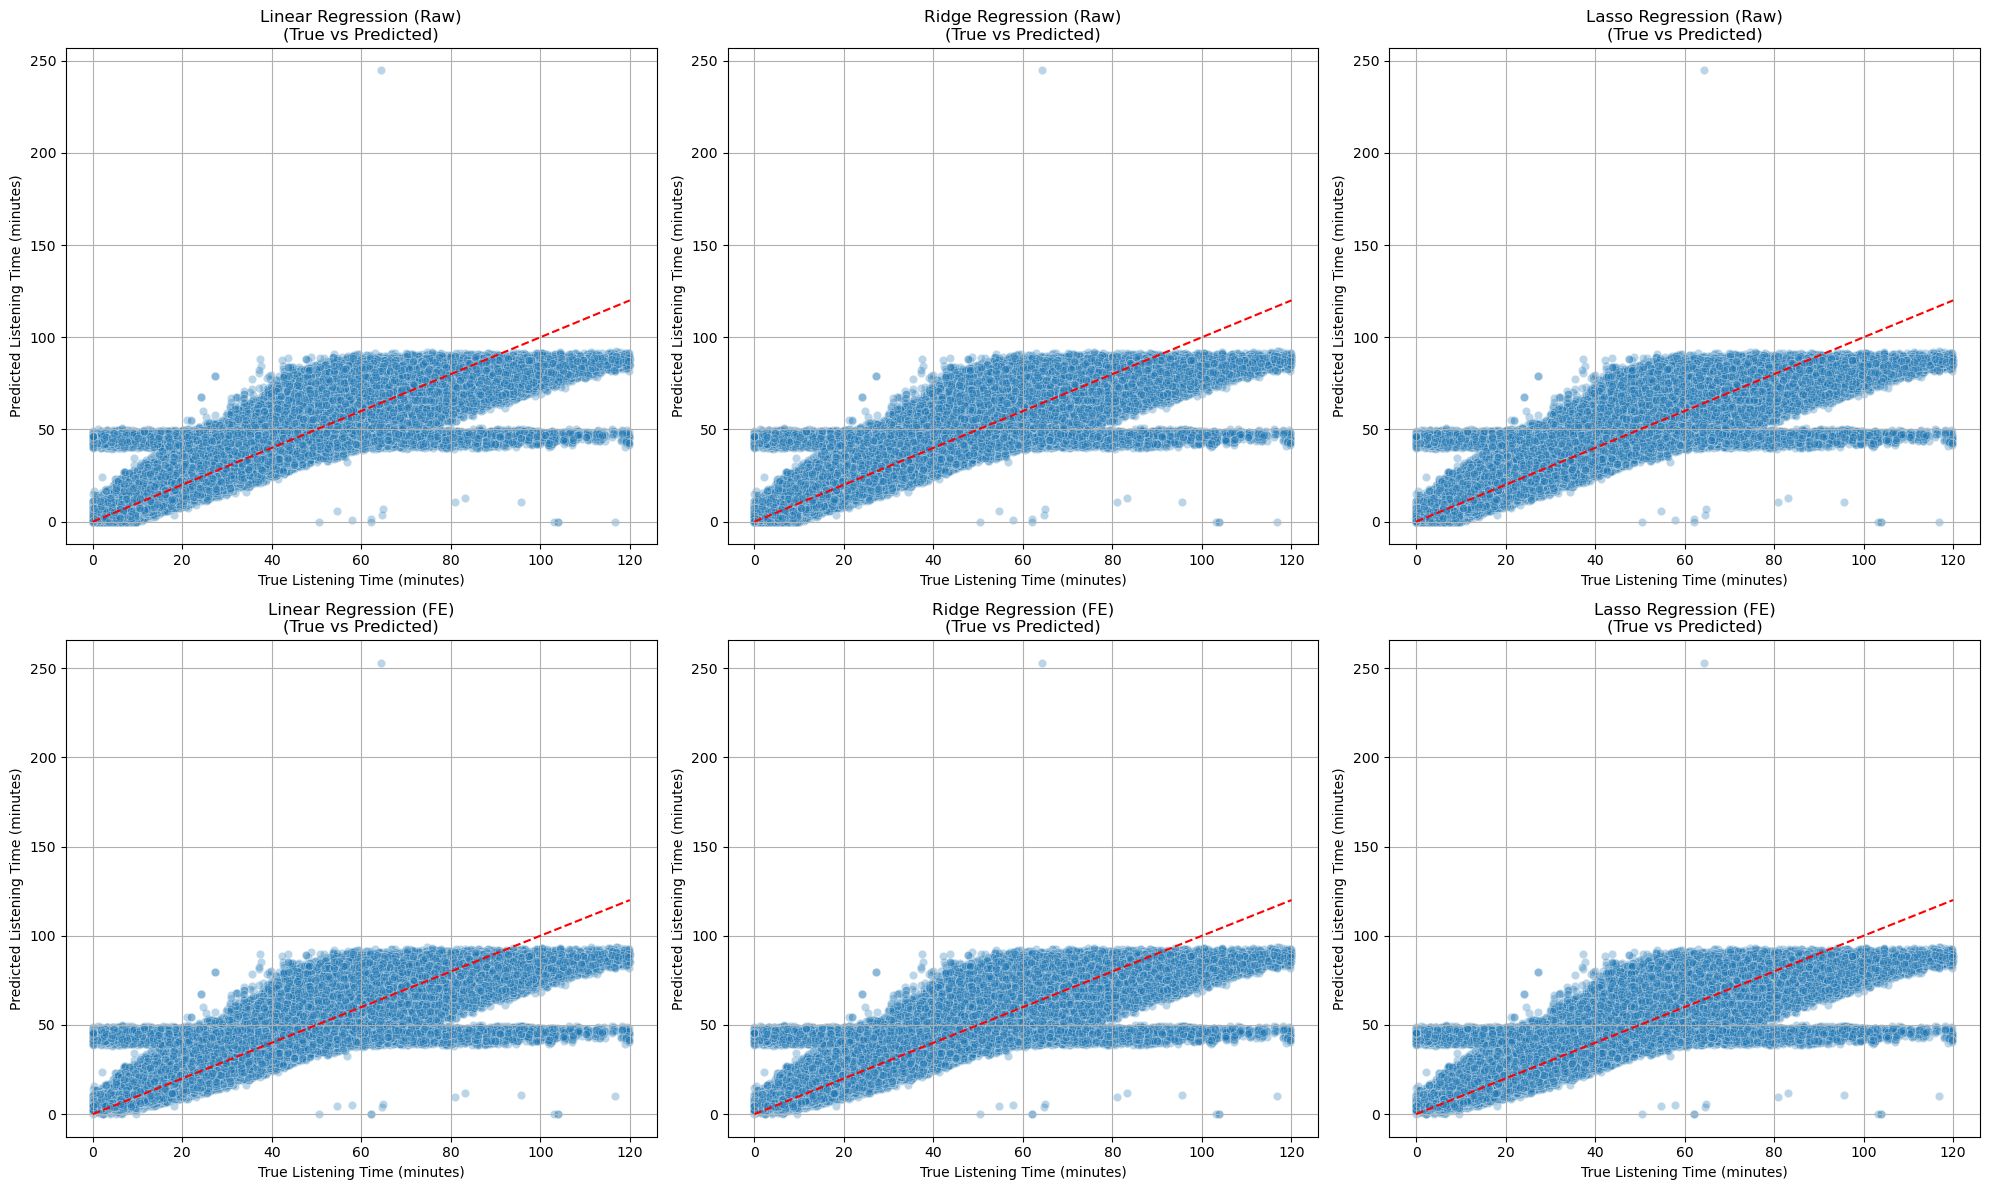

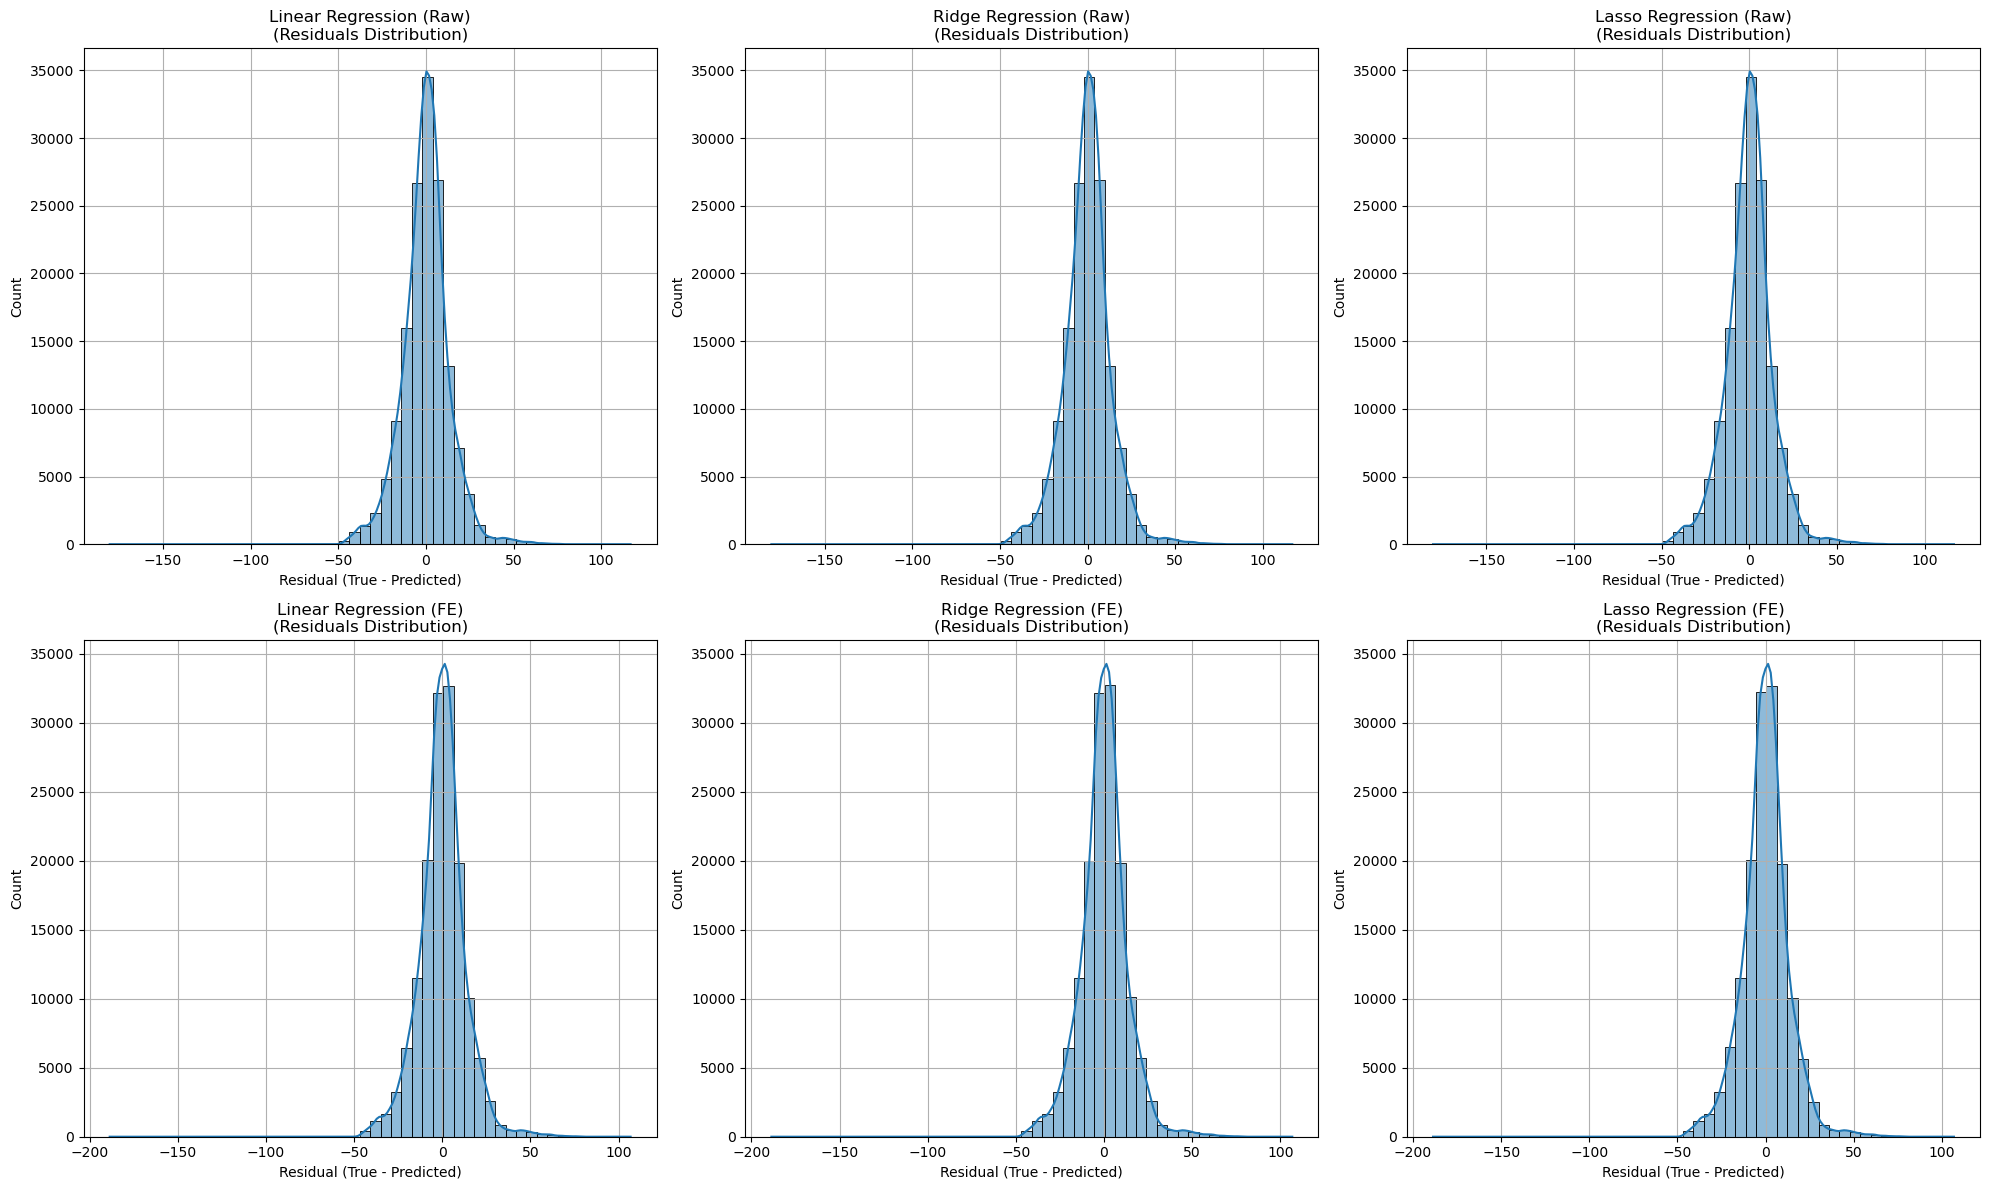

In [82]:
#Visualizations for Raw and FE Linear Models

#models and their predictions
models_info = [
    ('Linear Regression (Raw)', y_pred_linreg_raw, y_val_raw),
    ('Ridge Regression (Raw)', y_pred_ridge_raw, y_val_raw),
    ('Lasso Regression (Raw)', y_pred_lasso_raw, y_val_raw),
    ('Linear Regression (FE)', y_pred_linreg_fe, y_val_fe),
    ('Ridge Regression (FE)', y_pred_ridge_fe, y_val_fe),
    ('Lasso Regression (FE)', y_pred_lasso_fe, y_val_fe)
]

#figure with 2 rows and 3 columns
fig, axes = plt.subplots(2, 3, figsize=(20, 12))

# Scatterplots (True vs Predicted)
for idx, (model_name, y_pred_model, y_val_model) in enumerate(models_info):
    row = idx // 3
    col = idx % 3
    ax = axes[row, col]
    sns.scatterplot(x=y_val_model, y=y_pred_model, alpha=0.3, ax=ax)
    ax.plot([0, 120], [0, 120], 'r--')  # Perfect prediction line
    ax.set_xlabel('True Listening Time (minutes)')
    ax.set_ylabel('Predicted Listening Time (minutes)')
    ax.set_title(f'{model_name}\n(True vs Predicted)')
    ax.grid(True)

plt.tight_layout()
plt.show()

#Residual Histograms

fig, axes = plt.subplots(2, 3, figsize=(20, 12))

for idx, (model_name, y_pred_model, y_val_model) in enumerate(models_info):
    row = idx // 3
    col = idx % 3
    ax = axes[row, col]
    residuals = y_val_model - y_pred_model
    sns.histplot(residuals, bins=50, kde=True, ax=ax)
    ax.set_xlabel('Residual (True - Predicted)')
    ax.set_ylabel('Count')
    ax.set_title(f'{model_name}\n(Residuals Distribution)')
    ax.grid(True)

plt.tight_layout()
plt.show()

# MultiLayer Perceptron (MLP) Neural Network

In [18]:
#MLP neural network for raw and FE

#build MLP model
class OptimizedMLPv2(nn.Module):
    def __init__(self, input_dim):
        super(OptimizedMLPv2, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.LeakyReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.LeakyReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.LeakyReLU(),
            nn.Linear(32, 1)  # Regression output
        )
        
    def forward(self, x):
        return self.model(x)

# Evaluation Function for MLP

In [19]:
#evaluation function for MLP
def evaluate_mlp(y_true, y_pred, model_name):
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f'{model_name} Performance:')
    print(f'RMSE: {rmse:.4f}')
    print(f'MAE: {mae:.4f}')
    print(f'R^2 Score: {r2:.4f}')
    print('------------------------')
    return {'Model': model_name, 'RMSE': rmse, 'MAE': mae, 'R2': r2}

# Different Optimizer Test on MLP

In [64]:
#different optimizers on MLP

optimizers_to_try = ['SGD', 'Adam', 'RMSprop', 'Adagrad']

optimizer_results = []

#function to train MLP with specified optimizer
def train_mlp_with_optimizer(X_train_proc, y_train_array, X_val_proc, y_val_array, optimizer_name):

    X_train_tensor = torch.tensor(X_train_proc, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train_array.values, dtype=torch.float32).view(-1, 1)
    X_val_tensor = torch.tensor(X_val_proc, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val_array.values, dtype=torch.float32).view(-1, 1)

    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

    train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False)

    input_dim = X_train_proc.shape[1]
    model = OptimizedMLPv2(input_dim)  # use already defined model

    # Select optimizer
    if optimizer_name == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    elif optimizer_name == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=0.001)
    elif optimizer_name == 'RMSprop':
        optimizer = optim.RMSprop(model.parameters(), lr=0.001)
    elif optimizer_name == 'Adagrad':
        optimizer = optim.Adagrad(model.parameters(), lr=0.01)

    criterion = nn.MSELoss()

    best_val_loss = float('inf')
    patience = 10
    counter = 0

    epochs = 70

    for epoch in range(epochs):
        model.train()
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

        # Validation
        model.eval()
        running_val_loss = 0
        with torch.no_grad():
            for inputs, targets in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                running_val_loss += loss.item()
        avg_val_loss = running_val_loss / len(val_loader)

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                break
    # Final evaluation
    model.eval()
    with torch.no_grad():
        y_pred_val_tensor = model(X_val_tensor).squeeze()

    #NaN check inside PyTorch first
    if torch.isnan(y_pred_val_tensor).any():
        print(f"Optimizer {optimizer_name}: Model produced NaN predictions. Skipping.")
        return {'Model': f'MLP with {optimizer_name}', 'RMSE': np.nan, 'MAE': np.nan, 'R2': np.nan}

    y_pred_val = y_pred_val_tensor.numpy()

    y_pred_val = np.clip(y_pred_val, 0, None)

    # Normal evaluation
    rmse = mean_squared_error(y_val_array, y_pred_val, squared=False)
    mae = mean_absolute_error(y_val_array, y_pred_val)
    r2 = r2_score(y_val_array, y_pred_val)

    return {'Model': f'MLP with {optimizer_name}', 'RMSE': rmse, 'MAE': mae, 'R2': r2}


#train MLP with each optimizer
for opt_name in optimizers_to_try:
    result = train_mlp_with_optimizer(X_train_fe_proc, y_train_fe, X_val_fe_proc, y_val_fe, opt_name)
    optimizer_results.append(result)

#results
optimizer_results_df = pd.DataFrame(optimizer_results)
print(optimizer_results_df)
results_df = pd.concat([results_df, optimizer_results_df], ignore_index=True)

Optimizer SGD: Model produced NaN predictions. Skipping.
              Model       RMSE        MAE        R2
0      MLP with SGD        NaN        NaN       NaN
1     MLP with Adam  14.812958  10.779123  0.701800
2  MLP with RMSprop  13.307721   9.686967  0.759325
3  MLP with Adagrad  13.210906   9.647330  0.762814


# MLP Train Function Using Best Found Optimizer

In [27]:
#function to train MLP easily using best optimizer
def train_mlp(X_train_proc, y_train_array, X_val_proc, y_val_array, model_name):

    # Create TensorDatasets and DataLoaders
    X_train_tensor = torch.tensor(X_train_proc, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train_array.values, dtype=torch.float32).view(-1, 1)
    X_val_tensor = torch.tensor(X_val_proc, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val_array.values, dtype=torch.float32).view(-1, 1)

    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

    train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=512, shuffle=False)

    # Build model
    input_dim = X_train_proc.shape[1]
    model = OptimizedMLPv2(input_dim)
    optimizer = optim.Adagrad(model.parameters(), lr=0.01)
    criterion = nn.MSELoss()

    # Train model
    epochs = 30
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        running_train_loss = 0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()
        
        avg_train_loss = running_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        model.eval()
        running_val_loss = 0
        with torch.no_grad():
            for inputs, targets in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                running_val_loss += loss.item()
        
        avg_val_loss = running_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        if (epoch+1) % 5 == 0:
            print(f"Epoch {epoch+1}/{epochs}: Train Loss={avg_train_loss:.4f} | Val Loss={avg_val_loss:.4f}")

    # Final evaluation
    model.eval()
    with torch.no_grad():
        y_pred_val = model(X_val_tensor).squeeze().numpy()

    # Clip negative predictions
    y_pred_val = np.clip(y_pred_val, 0, None)

    return evaluate_mlp(y_val_array, y_pred_val, model_name)

# MLP Training on Raw and Feature Engineered Set

In [24]:
#train MLPs separately

mlp_results = []

# MLP on raw features
mlp_results.append(train_mlp(X_train_raw_proc, y_train_raw, X_val_raw_proc, y_val_raw, "MLP (Raw)"))

# MLP on FE features
mlp_results.append(train_mlp(X_train_fe_proc, y_train_fe, X_val_fe_proc, y_val_fe, "MLP (FE)"))

#results
mlp_results_df = pd.DataFrame(mlp_results)
print(mlp_results_df)
results_df = pd.concat([results_df, mlp_results_df], ignore_index=True)

Epoch 5/30: Train Loss=195.4238 | Val Loss=175.3087
Epoch 10/30: Train Loss=193.1410 | Val Loss=175.1631
Epoch 15/30: Train Loss=191.8208 | Val Loss=175.1072
Epoch 20/30: Train Loss=190.8840 | Val Loss=174.9147
Epoch 25/30: Train Loss=190.6013 | Val Loss=174.7478
Epoch 30/30: Train Loss=189.9550 | Val Loss=174.8915
MLP (Raw) Performance:
RMSE: 13.2248
MAE: 9.6651
R^2 Score: 0.7623
------------------------
Epoch 5/30: Train Loss=194.8573 | Val Loss=176.2724
Epoch 10/30: Train Loss=192.7377 | Val Loss=175.4900
Epoch 15/30: Train Loss=191.6496 | Val Loss=175.1024
Epoch 20/30: Train Loss=190.8112 | Val Loss=174.7930
Epoch 25/30: Train Loss=190.1131 | Val Loss=174.9489
Epoch 30/30: Train Loss=189.7021 | Val Loss=174.6526
MLP (FE) Performance:
RMSE: 13.2157
MAE: 9.6477
R^2 Score: 0.7626
------------------------
       Model       RMSE       MAE        R2
0  MLP (Raw)  13.224754  9.665125  0.762316
1   MLP (FE)  13.215716  9.647683  0.762641


# Optuna MLP Hyperparameter Tuning (note: takes an hour to complete)

In [28]:
#optuna MLP hyperparameter tuner

#objective function to optimize
def objective(trial):
    n_layers = trial.suggest_int('n_layers', 2, 4)
    hidden_dim = trial.suggest_int('hidden_dim', 64, 256)
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
    lr = trial.suggest_float('lr', 1e-4, 1e-2)

    # build model dynamically based on trial
    layers = []
    input_dim = X_train_fe_proc.shape[1]  # FE features recommended for tuning
    layers.append(nn.Linear(input_dim, hidden_dim))
    layers.append(nn.LeakyReLU())
    layers.append(nn.Dropout(dropout_rate))
    
    for _ in range(n_layers-1):
        layers.append(nn.Linear(hidden_dim, hidden_dim))
        layers.append(nn.LeakyReLU())
        layers.append(nn.Dropout(dropout_rate))
        
    layers.append(nn.Linear(hidden_dim, 1))  # output layer for regression

    model = nn.Sequential(*layers)
    
    optimizer = optim.Adagrad(model.parameters(), lr=lr)


    # loss
    criterion = nn.MSELoss()

    # dataloaders
    X_train_tensor = torch.tensor(X_train_fe_proc, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train_fe.values, dtype=torch.float32).view(-1, 1)
    X_val_tensor = torch.tensor(X_val_fe_proc, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val_fe.values, dtype=torch.float32).view(-1, 1)

    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

    train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False)

    # simple training loop (short for faster tuning)
    model.train()
    for epoch in range(20):
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

    # validation evaluation
    model.eval()
    with torch.no_grad():
        y_pred_val = model(X_val_tensor).squeeze().numpy()
    y_pred_val = np.clip(y_pred_val, 0, None)

    rmse = mean_squared_error(y_val_fe, y_pred_val, squared=False)

    return rmse

In [29]:
#optuna search

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=30)

print("\nBest Trial:")
print(study.best_trial.params)

[I 2025-04-27 01:59:28,837] A new study created in memory with name: no-name-2dedc10d-7259-4934-b960-d3f4e8575abd
[I 2025-04-27 02:01:08,346] Trial 0 finished with value: 13.231459519124083 and parameters: {'n_layers': 3, 'hidden_dim': 128, 'dropout_rate': 0.16525296098083514, 'lr': 0.004911777145706259}. Best is trial 0 with value: 13.231459519124083.
[I 2025-04-27 02:02:50,200] Trial 1 finished with value: 13.338992188081605 and parameters: {'n_layers': 2, 'hidden_dim': 227, 'dropout_rate': 0.2768758440234336, 'lr': 0.0012951477747398027}. Best is trial 0 with value: 13.231459519124083.
[I 2025-04-27 02:05:34,956] Trial 2 finished with value: 13.210959056153841 and parameters: {'n_layers': 4, 'hidden_dim': 251, 'dropout_rate': 0.11731430930885178, 'lr': 0.0035545962291447723}. Best is trial 2 with value: 13.210959056153841.
[I 2025-04-27 02:07:14,921] Trial 3 finished with value: 13.27156829076428 and parameters: {'n_layers': 2, 'hidden_dim': 232, 'dropout_rate': 0.256473961130685, '


Best Trial:
{'n_layers': 4, 'hidden_dim': 250, 'dropout_rate': 0.1437964466612175, 'lr': 0.008998835458804212}


# Train Best MLP Model With Optuna Hyperparams

In [44]:
#create MLP with best params
import torch.nn as nn
import torch.optim as optim

#model architecture based on best params
layers = []
input_dim = X_train_fe_proc.shape[1]  # FE features input dimension

hidden_dim = 250
n_layers = 4
dropout_rate = 0.1437964466612175
lr = 0.008998835458804212

layers.append(nn.Linear(input_dim, hidden_dim))
layers.append(nn.LeakyReLU())
layers.append(nn.Dropout(dropout_rate))

for _ in range(n_layers - 1):
    layers.append(nn.Linear(hidden_dim, hidden_dim))
    layers.append(nn.LeakyReLU())
    layers.append(nn.Dropout(dropout_rate))

# Output layer
layers.append(nn.Linear(hidden_dim, 1))  # Single output for regression

# Build the model
best_mlp_model = nn.Sequential(*layers)

#Define optimizer and loss
optimizer = optim.Adagrad(best_mlp_model.parameters(), lr=lr)
criterion = nn.MSELoss()

#Prepare data
X_train_tensor = torch.tensor(X_train_fe_proc, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_fe.values, dtype=torch.float32).view(-1, 1)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)

#Train model
best_mlp_model.train()
epochs = 70
                  
for epoch in range(epochs):
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = best_mlp_model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

# Best MLP Model With Optuna Hyperparams

In [45]:
#MLP with Optuna Hyperparams
X_val_tensor = torch.tensor(X_val_fe_proc, dtype=torch.float32)
best_mlp_model.eval()
with torch.no_grad():
    y_pred_val = best_mlp_model(X_val_tensor).squeeze().numpy()

# Clip predictions
y_pred_val = np.clip(y_pred_val, 0, None)

# evaluate best_mlp_model and append results

# metrics
rmse = mean_squared_error(y_val_fe, y_pred_val, squared=False)
mae = mean_absolute_error(y_val_fe, y_pred_val)
r2 = r2_score(y_val_fe, y_pred_val)

final_mlp_result = {
    'Model': 'Final Optimized MLP (Optuna Hyperparams)',
    'RMSE': rmse,
    'MAE': mae,
    'R2': r2
}

#results df
final_mlp_result_df = pd.DataFrame([final_mlp_result])

#Append
results_df = pd.concat([results_df, final_mlp_result_df], ignore_index=True)

print("\nFinal Optimized MLP Results:")
print(final_mlp_result)



Final Optimized MLP Results:
{'Model': 'Final Optimized MLP (Optuna Hyperparams)', 'RMSE': 13.203998309173485, 'MAE': 9.628221696615881, 'R2': 0.7630618450104485}


# MLP Ensemble With Adagrad Optimizer

In [30]:
#Ensemble of MLPs
#Function to train ONE MLP
def train_single_mlp(X_train_proc, y_train_array, X_val_proc, y_val_array, optimizer_name='Adagrad', epochs=50):
    
    X_train_tensor = torch.tensor(X_train_proc, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train_array.values, dtype=torch.float32).view(-1, 1)
    X_val_tensor = torch.tensor(X_val_proc, dtype=torch.float32)

    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)

    input_dim = X_train_proc.shape[1]
    model = OptimizedMLPv2(input_dim)
    
    if optimizer_name == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=0.001)
    elif optimizer_name == 'RMSprop':
        optimizer = optim.RMSprop(model.parameters(), lr=0.001)
    elif optimizer_name == 'Adagrad':
        optimizer = optim.Adagrad(model.parameters(), lr=0.01)  
    else:
        optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

    criterion = nn.MSELoss()

    model.train()
    for epoch in range(epochs):
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

    model.eval()
    with torch.no_grad():
        y_pred_val = model(X_val_tensor).squeeze().numpy()
    y_pred_val = np.clip(y_pred_val, 0, None)

    return y_pred_val

# Train MLP Ensemble

In [31]:
#Train Ensemble
n_models = 5  # Train 5 different MLPs
ensemble_preds = []

for i in range(n_models):
    print(f"Training MLP {i+1}/{n_models}...")
    preds = train_single_mlp(X_train_fe_proc, y_train_fe, X_val_fe_proc, y_val_fe, optimizer_name='Adagrad', epochs=70)
    ensemble_preds.append(preds)

Training MLP 1/5...
Training MLP 2/5...
Training MLP 3/5...
Training MLP 4/5...
Training MLP 5/5...


# MLP Ensemble Model

In [65]:
#Average Predictions
ensemble_preds = np.array(ensemble_preds)
final_preds = ensemble_preds.mean(axis=0)

#Final Evaluation
rmse = mean_squared_error(y_val_fe, final_preds, squared=False)
mae = mean_absolute_error(y_val_fe, final_preds)
r2 = r2_score(y_val_fe, final_preds)

ensemble_result = {
    'Model': 'Ensemble of 5 MLPs (Adagrad)',
    'RMSE': rmse,
    'MAE': mae,
    'R2': r2
}

print("\nEnsemble MLP Results:")
print(ensemble_result)

ensemble_result_df = pd.DataFrame([ensemble_result])

results_df = pd.concat([results_df, ensemble_result_df], ignore_index=True)


Ensemble MLP Results:
{'Model': 'Ensemble of 5 MLPs (Adagrad)', 'RMSE': 13.271379492730222, 'MAE': 9.695907313651364, 'R2': 0.7606374416151491}


# LightGBM Model

# Train LightGBM Model

In [36]:
# train LightGBM model 
# create datasets
lgb_train = lgb.Dataset(X_train_fe_proc, label=y_train_fe)
lgb_val = lgb.Dataset(X_val_fe_proc, label=y_val_fe, reference=lgb_train)

# params
lgb_params = {
    'objective': 'regression',
    'metric': 'rmse',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'verbose': -1
}

# train model with callbacks
lgb_model = lgb.train(
    params=lgb_params,
    train_set=lgb_train,
    valid_sets=[lgb_val],
    num_boost_round=500,
    callbacks=[
        early_stopping(stopping_rounds=20),
        log_evaluation(period=0)  
    ]
)

#predict on validation
lgb_preds = lgb_model.predict(X_val_fe_proc, num_iteration=lgb_model.best_iteration)
lgb_preds = np.clip(lgb_preds, 0, None)

#evaluate LightGBM
lgb_rmse = mean_squared_error(y_val_fe, lgb_preds, squared=False)
lgb_mae = mean_absolute_error(y_val_fe, lgb_preds)
lgb_r2 = r2_score(y_val_fe, lgb_preds)

lgb_result = {
    'Model': 'LightGBM',
    'RMSE': lgb_rmse,
    'MAE': lgb_mae,
    'R2': lgb_r2
}

print("\nLightGBM Results:")
print(lgb_result)


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's rmse: 13.0372

LightGBM Results:
{'Model': 'LightGBM', 'RMSE': 13.037176438526842, 'MAE': 9.496939844706837, 'R2': 0.7690110692999794}


# Optimize LightGBM with Optuna

In [37]:
#Optimize LightGBM with Optuna

#fefine Optuna objective function
def objective_lgb(trial):

    param = {
        'objective': 'regression',
        'metric': 'rmse',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 20, 200),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 10, 100),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.5, 1.0),
        'lambda_l1': trial.suggest_float('lambda_l1', 0.0, 5.0),
        'lambda_l2': trial.suggest_float('lambda_l2', 0.0, 5.0)
    }

    lgb_train = lgb.Dataset(X_train_fe_proc, label=y_train_fe)
    lgb_val = lgb.Dataset(X_val_fe_proc, label=y_val_fe)

    model = lgb.train(
        params=param,
        train_set=lgb_train,
        valid_sets=[lgb_val],
        num_boost_round=500,
        callbacks=[
            early_stopping(stopping_rounds=20),
            log_evaluation(period=0)  # ⬅️ Suppress logging
        ]
    )

    preds = model.predict(X_val_fe_proc, num_iteration=model.best_iteration)
    preds = np.clip(preds, 0, None)

    rmse = mean_squared_error(y_val_fe, preds, squared=False)

    return rmse

In [38]:
#Optuna search
study_lgb = optuna.create_study(direction="minimize")
study_lgb.optimize(objective_lgb, n_trials=30)  

# results
print("\nBest LightGBM Trial:")
print(study_lgb.best_trial.params)

[I 2025-04-27 03:25:10,166] A new study created in memory with name: no-name-6cff227b-a484-4a97-bd2e-035e14da9b99


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's rmse: 13.0903


[I 2025-04-27 03:25:13,815] Trial 0 finished with value: 13.09031469423214 and parameters: {'learning_rate': 0.058190853848263425, 'num_leaves': 54, 'max_depth': 4, 'min_data_in_leaf': 66, 'feature_fraction': 0.5116435876050804, 'bagging_fraction': 0.5293789548214829, 'lambda_l1': 2.190730255745221, 'lambda_l2': 4.873056473029678}. Best is trial 0 with value: 13.09031469423214.


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's rmse: 13.053


[I 2025-04-27 03:25:19,750] Trial 1 finished with value: 13.053011020129542 and parameters: {'learning_rate': 0.025591994866108997, 'num_leaves': 47, 'max_depth': 12, 'min_data_in_leaf': 13, 'feature_fraction': 0.5815169052801396, 'bagging_fraction': 0.9253642897749066, 'lambda_l1': 4.520596556723014, 'lambda_l2': 3.1058514029820667}. Best is trial 1 with value: 13.053011020129542.


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's rmse: 12.932


[I 2025-04-27 03:25:27,417] Trial 2 finished with value: 12.931976529474635 and parameters: {'learning_rate': 0.07875826067022103, 'num_leaves': 154, 'max_depth': 11, 'min_data_in_leaf': 86, 'feature_fraction': 0.9445028472292567, 'bagging_fraction': 0.705487486642519, 'lambda_l1': 0.4537250092824169, 'lambda_l2': 2.1152850224860305}. Best is trial 2 with value: 12.931976529474635.


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's rmse: 12.9602


[I 2025-04-27 03:25:32,029] Trial 3 finished with value: 12.960232927967873 and parameters: {'learning_rate': 0.10510796577472023, 'num_leaves': 76, 'max_depth': 10, 'min_data_in_leaf': 27, 'feature_fraction': 0.6463198663125572, 'bagging_fraction': 0.9655843132407373, 'lambda_l1': 1.520604257904063, 'lambda_l2': 0.8414828216454118}. Best is trial 2 with value: 12.931976529474635.


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[496]	valid_0's rmse: 12.9857


[I 2025-04-27 03:25:38,060] Trial 4 finished with value: 12.985669573683817 and parameters: {'learning_rate': 0.09285007275453581, 'num_leaves': 199, 'max_depth': 7, 'min_data_in_leaf': 62, 'feature_fraction': 0.5674448182567389, 'bagging_fraction': 0.7752510865310486, 'lambda_l1': 4.477296663317158, 'lambda_l2': 0.870721418374486}. Best is trial 2 with value: 12.931976529474635.


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's rmse: 13.0014


[I 2025-04-27 03:25:45,758] Trial 5 finished with value: 13.001391249583392 and parameters: {'learning_rate': 0.025548177325998882, 'num_leaves': 162, 'max_depth': 9, 'min_data_in_leaf': 30, 'feature_fraction': 0.6248719878389564, 'bagging_fraction': 0.7462146831410761, 'lambda_l1': 4.8349772834503355, 'lambda_l2': 2.3845513645545404}. Best is trial 2 with value: 12.931976529474635.


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's rmse: 12.9869


[I 2025-04-27 03:25:51,059] Trial 6 finished with value: 12.986850822606714 and parameters: {'learning_rate': 0.15355834694341983, 'num_leaves': 185, 'max_depth': 6, 'min_data_in_leaf': 77, 'feature_fraction': 0.647235276655038, 'bagging_fraction': 0.6475461370635949, 'lambda_l1': 2.4612543319812747, 'lambda_l2': 1.9802275468614177}. Best is trial 2 with value: 12.931976529474635.


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's rmse: 13.0112


[I 2025-04-27 03:25:55,988] Trial 7 finished with value: 13.011177393236704 and parameters: {'learning_rate': 0.09444976415325294, 'num_leaves': 181, 'max_depth': 6, 'min_data_in_leaf': 75, 'feature_fraction': 0.5353181962047855, 'bagging_fraction': 0.9749061040237657, 'lambda_l1': 2.7414179293345056, 'lambda_l2': 2.9349180478794463}. Best is trial 2 with value: 12.931976529474635.


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's rmse: 13.0751


[I 2025-04-27 03:26:00,338] Trial 8 finished with value: 13.07506557793751 and parameters: {'learning_rate': 0.07583620050280808, 'num_leaves': 146, 'max_depth': 4, 'min_data_in_leaf': 43, 'feature_fraction': 0.6998649243401359, 'bagging_fraction': 0.5655462475246114, 'lambda_l1': 3.5752764364631067, 'lambda_l2': 4.443909432997859}. Best is trial 2 with value: 12.931976529474635.


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's rmse: 13.0312


[I 2025-04-27 03:26:13,424] Trial 9 finished with value: 13.0312245912468 and parameters: {'learning_rate': 0.010921325435089965, 'num_leaves': 194, 'max_depth': 11, 'min_data_in_leaf': 10, 'feature_fraction': 0.663034404040675, 'bagging_fraction': 0.560588863539139, 'lambda_l1': 2.182021777874038, 'lambda_l2': 0.6367725728280221}. Best is trial 2 with value: 12.931976529474635.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[178]	valid_0's rmse: 12.9998


[I 2025-04-27 03:26:17,786] Trial 10 finished with value: 12.999742327586418 and parameters: {'learning_rate': 0.28440590276312094, 'num_leaves': 109, 'max_depth': 9, 'min_data_in_leaf': 94, 'feature_fraction': 0.9748201902915689, 'bagging_fraction': 0.8126859830449368, 'lambda_l1': 0.2859632455186141, 'lambda_l2': 1.719569977932348}. Best is trial 2 with value: 12.931976529474635.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[287]	valid_0's rmse: 12.9779


[I 2025-04-27 03:26:22,721] Trial 11 finished with value: 12.977842975481854 and parameters: {'learning_rate': 0.23422390193282527, 'num_leaves': 101, 'max_depth': 10, 'min_data_in_leaf': 97, 'feature_fraction': 0.8249883065530802, 'bagging_fraction': 0.8760223215442422, 'lambda_l1': 0.534907922179165, 'lambda_l2': 1.155599669411696}. Best is trial 2 with value: 12.931976529474635.


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's rmse: 13.0105


[I 2025-04-27 03:26:29,768] Trial 12 finished with value: 13.01054758634335 and parameters: {'learning_rate': 0.034480445098889735, 'num_leaves': 79, 'max_depth': 12, 'min_data_in_leaf': 39, 'feature_fraction': 0.8100583006901587, 'bagging_fraction': 0.6941038423083785, 'lambda_l1': 1.0848530975345199, 'lambda_l2': 0.047816962439951816}. Best is trial 2 with value: 12.931976529474635.


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's rmse: 12.9374


[I 2025-04-27 03:26:34,521] Trial 13 finished with value: 12.93737266989739 and parameters: {'learning_rate': 0.13950041951228037, 'num_leaves': 136, 'max_depth': 10, 'min_data_in_leaf': 26, 'feature_fraction': 0.9552474204092605, 'bagging_fraction': 0.8469902267281195, 'lambda_l1': 1.2568393594355585, 'lambda_l2': 3.7443989320321065}. Best is trial 2 with value: 12.931976529474635.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[351]	valid_0's rmse: 12.9581


[I 2025-04-27 03:26:39,426] Trial 14 finished with value: 12.958131901749372 and parameters: {'learning_rate': 0.16564258566761825, 'num_leaves': 138, 'max_depth': 8, 'min_data_in_leaf': 48, 'feature_fraction': 0.9872919027204733, 'bagging_fraction': 0.8439051242218474, 'lambda_l1': 1.163520577007385, 'lambda_l2': 3.8248553806701713}. Best is trial 2 with value: 12.931976529474635.


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's rmse: 12.9642


[I 2025-04-27 03:26:45,787] Trial 15 finished with value: 12.964179828293751 and parameters: {'learning_rate': 0.050946416647615095, 'num_leaves': 136, 'max_depth': 11, 'min_data_in_leaf': 83, 'feature_fraction': 0.8986061019338163, 'bagging_fraction': 0.6611727295908372, 'lambda_l1': 0.09322593877016772, 'lambda_l2': 3.5736930714429676}. Best is trial 2 with value: 12.931976529474635.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[419]	valid_0's rmse: 12.9347


[I 2025-04-27 03:26:50,700] Trial 16 finished with value: 12.934735654924495 and parameters: {'learning_rate': 0.1521312617164585, 'num_leaves': 160, 'max_depth': 10, 'min_data_in_leaf': 23, 'feature_fraction': 0.9092936746229503, 'bagging_fraction': 0.7288254752258664, 'lambda_l1': 0.8458840494973252, 'lambda_l2': 3.95835401266676}. Best is trial 2 with value: 12.931976529474635.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[270]	valid_0's rmse: 12.9652


[I 2025-04-27 03:26:54,686] Trial 17 finished with value: 12.965230350739823 and parameters: {'learning_rate': 0.1905400667800417, 'num_leaves': 163, 'max_depth': 8, 'min_data_in_leaf': 60, 'feature_fraction': 0.8919313074669907, 'bagging_fraction': 0.6169653065710083, 'lambda_l1': 0.8926760469179812, 'lambda_l2': 2.6108762621709327}. Best is trial 2 with value: 12.931976529474635.


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's rmse: 13.0561


[I 2025-04-27 03:26:58,389] Trial 18 finished with value: 13.056120782880276 and parameters: {'learning_rate': 0.04703934493573482, 'num_leaves': 23, 'max_depth': 11, 'min_data_in_leaf': 52, 'feature_fraction': 0.886895031108071, 'bagging_fraction': 0.7215210417169124, 'lambda_l1': 1.7940955921689161, 'lambda_l2': 4.293592505107612}. Best is trial 2 with value: 12.931976529474635.


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's rmse: 12.9435


[I 2025-04-27 03:27:06,361] Trial 19 finished with value: 12.943463743851458 and parameters: {'learning_rate': 0.12131327262162198, 'num_leaves': 170, 'max_depth': 9, 'min_data_in_leaf': 87, 'feature_fraction': 0.7712184453911888, 'bagging_fraction': 0.7668629423331758, 'lambda_l1': 0.6545610888684694, 'lambda_l2': 1.9920907974728344}. Best is trial 2 with value: 12.931976529474635.


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's rmse: 13.0394


[I 2025-04-27 03:27:16,463] Trial 20 finished with value: 13.039405881440603 and parameters: {'learning_rate': 0.010898411220690204, 'num_leaves': 123, 'max_depth': 12, 'min_data_in_leaf': 70, 'feature_fraction': 0.9284061436760274, 'bagging_fraction': 0.693253609414258, 'lambda_l1': 3.0829283207624845, 'lambda_l2': 3.247378370915831}. Best is trial 2 with value: 12.931976529474635.


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's rmse: 12.9387


[I 2025-04-27 03:27:21,845] Trial 21 finished with value: 12.93864126337809 and parameters: {'learning_rate': 0.1409430357548418, 'num_leaves': 150, 'max_depth': 10, 'min_data_in_leaf': 23, 'feature_fraction': 0.9462640219672855, 'bagging_fraction': 0.8832168690905089, 'lambda_l1': 1.4386449412365327, 'lambda_l2': 3.9108296553752164}. Best is trial 2 with value: 12.931976529474635.


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's rmse: 12.9457


[I 2025-04-27 03:27:27,668] Trial 22 finished with value: 12.945675917148716 and parameters: {'learning_rate': 0.07550176652994404, 'num_leaves': 125, 'max_depth': 10, 'min_data_in_leaf': 37, 'feature_fraction': 0.8432746996999592, 'bagging_fraction': 0.8080626823933389, 'lambda_l1': 0.002179994852670286, 'lambda_l2': 4.921896210185448}. Best is trial 2 with value: 12.931976529474635.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[229]	valid_0's rmse: 12.9649


[I 2025-04-27 03:27:30,226] Trial 23 finished with value: 12.964912981066234 and parameters: {'learning_rate': 0.20832822369987947, 'num_leaves': 156, 'max_depth': 11, 'min_data_in_leaf': 19, 'feature_fraction': 0.9452225683418717, 'bagging_fraction': 0.8024095212739691, 'lambda_l1': 0.6301960632118004, 'lambda_l2': 4.267663641599495}. Best is trial 2 with value: 12.931976529474635.


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[499]	valid_0's rmse: 12.958


[I 2025-04-27 03:27:35,601] Trial 24 finished with value: 12.958043071168587 and parameters: {'learning_rate': 0.07413599312007046, 'num_leaves': 123, 'max_depth': 9, 'min_data_in_leaf': 32, 'feature_fraction': 0.8568672985575938, 'bagging_fraction': 0.7295338638561623, 'lambda_l1': 1.6393045894516662, 'lambda_l2': 2.7800845949522897}. Best is trial 2 with value: 12.931976529474635.


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[499]	valid_0's rmse: 13.084


[I 2025-04-27 03:27:38,326] Trial 25 finished with value: 13.08396525713188 and parameters: {'learning_rate': 0.12966251488503194, 'num_leaves': 174, 'max_depth': 3, 'min_data_in_leaf': 18, 'feature_fraction': 0.7574322869090484, 'bagging_fraction': 0.6184979906086452, 'lambda_l1': 1.0287655823536763, 'lambda_l2': 3.6275888430055394}. Best is trial 2 with value: 12.931976529474635.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[278]	valid_0's rmse: 12.9973


[I 2025-04-27 03:27:41,936] Trial 26 finished with value: 12.997270022432938 and parameters: {'learning_rate': 0.2893441298026355, 'num_leaves': 92, 'max_depth': 7, 'min_data_in_leaf': 45, 'feature_fraction': 0.978230813502637, 'bagging_fraction': 0.8918954389835213, 'lambda_l1': 0.39958668705241074, 'lambda_l2': 2.26754527536647}. Best is trial 2 with value: 12.931976529474635.


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's rmse: 12.9339


[I 2025-04-27 03:27:47,381] Trial 27 finished with value: 12.933854089429879 and parameters: {'learning_rate': 0.10747106289503221, 'num_leaves': 137, 'max_depth': 11, 'min_data_in_leaf': 56, 'feature_fraction': 0.9992775706448291, 'bagging_fraction': 0.8520627721737705, 'lambda_l1': 1.365116765051403, 'lambda_l2': 3.3446669422273083}. Best is trial 2 with value: 12.931976529474635.


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's rmse: 12.9502


[I 2025-04-27 03:27:53,467] Trial 28 finished with value: 12.950224538620674 and parameters: {'learning_rate': 0.06056685851143318, 'num_leaves': 152, 'max_depth': 12, 'min_data_in_leaf': 54, 'feature_fraction': 0.9159178538332949, 'bagging_fraction': 0.6715360753423847, 'lambda_l1': 0.8122468231267077, 'lambda_l2': 1.3942419913008126}. Best is trial 2 with value: 12.931976529474635.


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's rmse: 12.983


[I 2025-04-27 03:27:59,924] Trial 29 finished with value: 12.982960324296503 and parameters: {'learning_rate': 0.04371156308862915, 'num_leaves': 114, 'max_depth': 11, 'min_data_in_leaf': 68, 'feature_fraction': 0.7940079272290441, 'bagging_fraction': 0.7852037861276067, 'lambda_l1': 1.9923581628732885, 'lambda_l2': 3.2819309151437404}. Best is trial 2 with value: 12.931976529474635.



Best LightGBM Trial:
{'learning_rate': 0.07875826067022103, 'num_leaves': 154, 'max_depth': 11, 'min_data_in_leaf': 86, 'feature_fraction': 0.9445028472292567, 'bagging_fraction': 0.705487486642519, 'lambda_l1': 0.4537250092824169, 'lambda_l2': 2.1152850224860305}


# Train Best LightBGM with Optuna Hyperparams

In [47]:
#LightBGM with Optuna params

#hyperparameters from Optuna
best_lgbm_params = {
    'learning_rate': 0.07875826067022103,
    'num_leaves': 154,
    'max_depth': 11,
    'min_data_in_leaf': 86,
    'feature_fraction': 0.9445028472292567,
    'bagging_fraction': 0.705487486642519,
    'lambda_l1': 0.4537250092824169,
    'lambda_l2': 2.1152850224860305,
    
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'verbosity': -1
}

# create Datasets
train_data = lgb.Dataset(X_train_fe_proc, label=y_train_fe)
val_data = lgb.Dataset(X_val_fe_proc, label=y_val_fe)

# train LightGBM model
best_lgbm_model = lgb.train(
    best_lgbm_params,
    train_set=train_data,
    valid_sets=[val_data],
    num_boost_round=500,
    callbacks=[
        lgb.early_stopping(stopping_rounds=20),
        lgb.log_evaluation(period=0)
    ]
)

Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's rmse: 12.932


# Best LightBGM Model

In [48]:
# predict on validation set
lgbm_preds = best_lgbm_model.predict(X_val_fe_proc, num_iteration=best_lgbm_model.best_iteration)
lgbm_preds = np.clip(lgbm_preds, 0, None)  # No negative listening times

# evaluate
rmse = mean_squared_error(y_val_fe, lgbm_preds, squared=False)
mae = mean_absolute_error(y_val_fe, lgbm_preds)
r2 = r2_score(y_val_fe, lgbm_preds)

final_lgbm_result = {
    'Model': 'Final Optimized LightGBM (Optuna Hyperparams)',
    'RMSE': rmse,
    'MAE': mae,
    'R2': r2
}

# results df
final_lgbm_result_df = pd.DataFrame([final_lgbm_result])

# append
results_df = pd.concat([results_df, final_lgbm_result_df], ignore_index=True)

print("\nFinal Optimized LightGBM Results:")
print(final_lgbm_result)


Final Optimized LightGBM Results:
{'Model': 'Final Optimized LightGBM (Optuna Hyperparams)', 'RMSE': 12.931976529474673, 'MAE': 9.37924196656609, 'R2': 0.7727238323318348}


# Full Stack Ensemble Model (All Models)

In [52]:
#full stack ensemble model

#generate base model predictions

# Predict on validation set
linreg_preds = np.clip(linreg_fe.predict(X_val_fe_proc), 0, None)
ridge_preds = np.clip(ridge_fe.predict(X_val_fe_proc), 0, None)
lasso_preds = np.clip(lasso_fe.predict(X_val_fe_proc), 0, None)

# Final MLP (Best Optuna model)
X_val_tensor = torch.tensor(X_val_fe_proc, dtype=torch.float32)
best_mlp_model.eval()
with torch.no_grad():
    mlp_preds = best_mlp_model(X_val_tensor).squeeze().numpy()
mlp_preds = np.clip(mlp_preds, 0, None)

# Final LightGBM (Best Optuna model)
lgbm_preds = best_lgbm_model.predict(X_val_fe_proc, num_iteration=best_lgbm_model.best_iteration)
lgbm_preds = np.clip(lgbm_preds, 0, None)

# Ensemble of 5 MLPs averaged
ensemble_preds = np.clip(ensemble_preds, 0, None)

#stack predictions into a feature matrix


stacked_X_val = np.vstack([
    linreg_preds,
    ridge_preds,
    lasso_preds,
    mlp_preds,
    lgbm_preds,
    ensemble_preds
]).T  # shape (n_samples, 6 models)

print("Stacked feature matrix shape:", stacked_X_val.shape)

#train meta-model

meta_model = Ridge(alpha=1.0)  # You can change meta-learner if you want
meta_model.fit(stacked_X_val, y_val_fe)

#predict final outputs

stacked_preds = np.clip(meta_model.predict(stacked_X_val), 0, None)

#evaluate etacked ensemble

stacked_rmse = mean_squared_error(y_val_fe, stacked_preds, squared=False)
stacked_mae = mean_absolute_error(y_val_fe, stacked_preds)
stacked_r2 = r2_score(y_val_fe, stacked_preds)

stacked_result = {
    'Model': 'Stacked Ensemble (All Models)',
    'RMSE': stacked_rmse,
    'MAE': stacked_mae,
    'R2': stacked_r2
}

stacked_result_df = pd.DataFrame([stacked_result])

# append

results_df = pd.concat([results_df, stacked_result_df], ignore_index=True)

print("\nFinal Stacked Ensemble Results:")
print(stacked_result)


Stacked feature matrix shape: (150000, 10)

Final Stacked Ensemble Results:
{'Model': 'Stacked Ensemble (All Models)', 'RMSE': 12.93072857895466, 'MAE': 9.381625536101208, 'R2': 0.7727676950353743}


# Kyler's CatBoost Model

# Model Training

In [85]:
# create datasets
train_data = Pool(X_train_fe_proc, label=y_train_fe)
val_data = Pool(X_val_fe_proc, label=y_val_fe)

# params
catboost_params = {
    'objective': 'RMSE',
    'learning_rate': 0.05,
    'depth': 6,  # depth parameter for CatBoost
    'iterations': 500,
    'verbose': 0,
    'early_stopping_rounds': 20
}

# train model
catboost_model = CatBoostRegressor(**catboost_params)
catboost_model.fit(train_data, eval_set=val_data, use_best_model=True)

# predict on validation
catboost_preds = catboost_model.predict(X_val_fe_proc)
catboost_preds = np.clip(catboost_preds, 0, None)

# evaluate CatBoost
catboost_rmse = mean_squared_error(y_val_fe, catboost_preds, squared=False)
catboost_mae = mean_absolute_error(y_val_fe, catboost_preds)
catboost_r2 = r2_score(y_val_fe, catboost_preds)

catboost_result = {
    'Model': 'CatBoost',
    'RMSE': catboost_rmse,
    'MAE': catboost_mae,
    'R2': catboost_r2
}

print("\nCatBoost Results:")
print(catboost_result)


CatBoost Results:
{'Model': 'CatBoost', 'RMSE': 13.0902202793706, 'MAE': 9.539330447845714, 'R2': 0.7671276145740781}


# Hyperparamter Tuning

In [86]:
# Define Optuna objective function for CatBoost
def objective_catboost(trial):
    
    param = {
        'objective': 'RMSE',  
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'depth': trial.suggest_int('depth', 3, 12),  
        'iterations': trial.suggest_int('iterations', 100, 1000),  
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-5, 100.0, log=True), 
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0, 1.0),  
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.5, 1.0),  
        'border_count': trial.suggest_int('border_count', 32, 255),  
        'random_state': 42 
    }

    # Initialize CatBoostRegressor
    model = CatBoostRegressor(**param)

    # Fit the model with early stopping
    model.fit(X_train_fe_proc, y_train_fe, 
              eval_set=(X_val_fe_proc, y_val_fe),
              early_stopping_rounds=20,  
              verbose=False) 
    
    # Predict and evaluate on validation set, ensure positivity 
    preds = model.predict(X_val_fe_proc)
    preds = np.clip(preds, 0, None) 

    rmse = mean_squared_error(y_val_fe, preds, squared=False) 

    return rmse

# Minimization Trials

In [87]:
# Perform 30 trials to minimize RMSE 
study_catboost = optuna.create_study(direction="minimize")  
study_catboost.optimize(objective_catboost, n_trials=30)  

# Print results 
print("\nBest CatBoost Trial:")
print(study_catboost.best_trial.params)

[I 2025-04-27 16:40:36,871] A new study created in memory with name: no-name-6282fce5-aca5-4751-bda3-9935773b50be
[I 2025-04-27 16:41:03,094] Trial 0 finished with value: 13.08352167225138 and parameters: {'learning_rate': 0.030196598448428074, 'depth': 12, 'iterations': 348, 'l2_leaf_reg': 0.5473976831370577, 'bagging_temperature': 0.9014306352863753, 'colsample_bylevel': 0.7285419527498037, 'border_count': 251}. Best is trial 0 with value: 13.08352167225138.
[I 2025-04-27 16:41:17,652] Trial 1 finished with value: 13.140284002904723 and parameters: {'learning_rate': 0.0335463528701953, 'depth': 12, 'iterations': 134, 'l2_leaf_reg': 10.619514876668605, 'bagging_temperature': 0.9897700676553133, 'colsample_bylevel': 0.8765372893830718, 'border_count': 226}. Best is trial 0 with value: 13.08352167225138.
[I 2025-04-27 16:41:46,712] Trial 2 finished with value: 13.150184763158412 and parameters: {'learning_rate': 0.013925356769072389, 'depth': 7, 'iterations': 491, 'l2_leaf_reg': 0.55485

[I 2025-04-27 16:51:04,750] Trial 23 finished with value: 12.987680262468245 and parameters: {'learning_rate': 0.05070081077514104, 'depth': 11, 'iterations': 855, 'l2_leaf_reg': 0.13547938656762432, 'bagging_temperature': 0.5827087231558015, 'colsample_bylevel': 0.9128697050525025, 'border_count': 162}. Best is trial 21 with value: 12.98583219164755.
[I 2025-04-27 16:51:48,235] Trial 24 finished with value: 12.99017061840783 and parameters: {'learning_rate': 0.04882067137642051, 'depth': 11, 'iterations': 871, 'l2_leaf_reg': 0.0790656953762743, 'bagging_temperature': 0.5953891334466804, 'colsample_bylevel': 0.9310437033507695, 'border_count': 180}. Best is trial 21 with value: 12.98583219164755.
[I 2025-04-27 16:52:29,159] Trial 25 finished with value: 12.975495266552235 and parameters: {'learning_rate': 0.06789633338345015, 'depth': 12, 'iterations': 592, 'l2_leaf_reg': 0.05444820866760144, 'bagging_temperature': 0.4621763308846617, 'colsample_bylevel': 0.8512197318810643, 'border_co


Best CatBoost Trial:
{'learning_rate': 0.06789633338345015, 'depth': 12, 'iterations': 592, 'l2_leaf_reg': 0.05444820866760144, 'bagging_temperature': 0.4621763308846617, 'colsample_bylevel': 0.8512197318810643, 'border_count': 213}


# Model Training (Best Parameters) 

In [88]:
# Define the best params
best_catboost_params = {
    'learning_rate': 0.053156533135846354,
    'depth': 11,
    'iterations': 735,
    'l2_leaf_reg': 0.5537806027515884,
    'bagging_temperature': 0.966594578770241,
    'colsample_bylevel': 0.7327316098447535,
    'border_count': 136,
    'random_state': 42,   
    'verbose': False      
}

# Train model
catboost_model = CatBoostRegressor(**best_catboost_params)
catboost_model.fit(
    X_train_fe_proc, y_train_fe, 
    eval_set=(X_val_fe_proc, y_val_fe), 
    early_stopping_rounds=20
)

# Prediction 

In [89]:
# Predict on validation set
catboost_preds = catboost_model.predict(X_val_fe_proc)
catboost_preds = np.clip(catboost_preds, 0, None)  

# Evaluate
catboost_rmse = mean_squared_error(y_val_fe, catboost_preds, squared=False)
catboost_mae = mean_absolute_error(y_val_fe, catboost_preds)
catboost_r2 = r2_score(y_val_fe, catboost_preds)

final_catboost_result = {
    'Model': 'Final Optimized CatBoost (Optuna Hyperparams)',
    'RMSE': catboost_rmse,
    'MAE': catboost_mae,
    'R2': catboost_r2
}

# Results DataFrame
final_catboost_result_df = pd.DataFrame([final_catboost_result])

# Append to dataframe
results_df = pd.concat([results_df, final_catboost_result_df], ignore_index=True)

print("\nFinal Optimized CatBoost Results:")
print(final_catboost_result)


Final Optimized CatBoost Results:
{'Model': 'Final Optimized CatBoost (Optuna Hyperparams)', 'RMSE': 12.997247254066897, 'MAE': 9.454901086873276, 'R2': 0.7704238101092351}


# Sean's LightGBM Model and Kaggle Submission

In [ ]:
# Load data
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

# Drop high-cardinality columns
drop_cols = ["Podcast_Name"]
train = train.drop(columns=drop_cols)
test = test.drop(columns=drop_cols)

# Feature Engineering 

In [ ]:
def extract_episode_number(title):
    match = re.search(r"(\d+)", str(title))
    return int(match.group(1)) if match else np.nan

for df in [train, test]:
    # Episode number from title
    df["Episode_Number"] = df["Episode_Title"].apply(extract_episode_number)
    
    # Has guest flag
    df["Has_Guest"] = df["Guest_Popularity_percentage"].notnull().astype(int)
    
    # Effective episode length (less ads)
    df["Effective_Length"] = df["Episode_Length_minutes"] - (df["Number_of_Ads"].fillna(0) * 2.5)
    
    # Map sentiment to numeric
    sentiment_map = {"Positive": 1, "Neutral": 0, "Negative": -1}
    df["Sentiment_Score"] = df["Episode_Sentiment"].map(sentiment_map)
    
    # Is weekend publication
    df["Is_Weekend"] = df["Publication_Day"].isin(["Saturday", "Sunday"]).astype(int)

# Drop original unused columns
drop_feats = ["Episode_Title", "Episode_Sentiment"]
train = train.drop(columns=drop_feats)
test = test.drop(columns=drop_feats)

# Prepare data

In [ ]:
y = train["Listening_Time_minutes"]
X = train.drop(columns=["Listening_Time_minutes", "id"])
X_test = test.drop(columns=["id"])
test_ids = test["id"]

# Handle categoricals 

In [ ]:
cat_cols = X.select_dtypes(include="object").columns.tolist()
for col in cat_cols:
    X[col] = X[col].astype("category")
    X_test[col] = X_test[col].astype("category")

# Train-validation split

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# LightGBM datasets

In [ ]:
train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=cat_cols)
val_data = lgb.Dataset(X_val, label=y_val, categorical_feature=cat_cols, reference=train_data)

# LightGBM Parameters

In [ ]:
params = {
    "objective": "regression",
    "metric": "rmse",
    "boosting_type": "gbdt",
    "learning_rate": 0.05,
    "num_leaves": 64,
    "max_depth": -1,
    "min_data_in_leaf": 20,
    "feature_fraction": 0.9,
    "bagging_fraction": 0.8,
    "bagging_freq": 5,
    "verbosity": -1,
    "random_state": 42,
}

# Training 

In [ ]:
model = lgb.train(
    params,
    train_data,
    valid_sets=[train_data, val_data],
    num_boost_round=2000,
    callbacks=[
        lgb.early_stopping(stopping_rounds=50),
        lgb.log_evaluation(period=100)
    ]
)

# Evaluate

In [ ]:
val_preds = model.predict(X_val, num_iteration=model.best_iteration)
rmse = np.sqrt(mean_squared_error(y_val, val_preds))
print(f"LightGBM Tuned Validation RMSE: {rmse:.5f}")

# Final LightGBM Model

In [92]:
# Retrain on full data
full_data = lgb.Dataset(X, label=y, categorical_feature=cat_cols)
final_model = lgb.train(params, full_data, num_boost_round=model.best_iteration)

# Predict test set
test_preds = final_model.predict(X_test)

# Save submission
submission = pd.DataFrame({
    "id": test_ids,
    "Listening_Time_minutes": test_preds
})
submission.to_csv("9thsubmission.csv", index=False)
print("Final submission file saved as '9thsubmission.csv'")

Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 13.001	valid_1's rmse: 13.0542
[200]	training's rmse: 12.8623	valid_1's rmse: 13.016
[300]	training's rmse: 12.7532	valid_1's rmse: 12.9914
[400]	training's rmse: 12.6462	valid_1's rmse: 12.9731
[500]	training's rmse: 12.5645	valid_1's rmse: 12.9577
[600]	training's rmse: 12.4733	valid_1's rmse: 12.9443
[700]	training's rmse: 12.3918	valid_1's rmse: 12.9334
[800]	training's rmse: 12.3185	valid_1's rmse: 12.9239
[900]	training's rmse: 12.2356	valid_1's rmse: 12.9139
[1000]	training's rmse: 12.1584	valid_1's rmse: 12.9049
[1100]	training's rmse: 12.0934	valid_1's rmse: 12.899
[1200]	training's rmse: 12.0259	valid_1's rmse: 12.895
[1300]	training's rmse: 11.9525	valid_1's rmse: 12.886
[1400]	training's rmse: 11.8835	valid_1's rmse: 12.8802
[1500]	training's rmse: 11.8121	valid_1's rmse: 12.8766
[1600]	training's rmse: 11.748	valid_1's rmse: 12.8733
[1700]	training's rmse: 11.6848	valid_1's rmse: 12.8668
[1

# Save LightGBM Results

In [106]:
mae = mean_absolute_error(y_val, val_preds)
r2 = r2_score(y_val, val_preds)
final_lightgbm_result = {
    'Model': 'LightGBM (Final - Kaggle Submission)',
    'RMSE': rmse,
    'MAE': mae,
    'R2': r2
}

final_lightgbm_df = pd.DataFrame([final_lightgbm_result])

results_df = pd.concat([results_df, final_lightgbm_df], ignore_index=True)

print("Final LightGBM evaluation added to results_df:")
display(results_df.tail(5))

Final LightGBM evaluation added to results_df:


,Model,RMSE,MAE,R2,Type
11,Final Optimized MLP (Optuna Hyperparams),13.203998,9.628222,0.763062,Neural Net
12,Final Optimized LightGBM (Optuna Hyperparams),12.931977,9.379242,0.772724,Tree-Based
13,Stacked Ensemble (All Models),12.930729,9.381626,0.772768,Ensemble
14,Final Optimized CatBoost (Optuna Hyperparams),12.997247,9.454901,0.770424,NaN
15,LightGBM (Final - Kaggle Submission),12.855765,9.337937,0.775395,NaN


# Sean's XGBoost Model 

# Load data

In [ ]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

# Save IDs
test_ids = test["id"]

# Drop high-cardinality text columns
drop_cols = ["Podcast_Name"]
train = train.drop(columns=drop_cols)
test = test.drop(columns=drop_cols)

# Feature Engineering

In [ ]:
def extract_episode_number(title):
    match = re.search(r"(\\d+)", str(title))
    return int(match.group(1)) if match else np.nan

for df in [train, test]:
    df["Episode_Number"] = df["Episode_Title"].apply(extract_episode_number)
    df["Has_Guest"] = df["Guest_Popularity_percentage"].notnull().astype(int)
    df["Effective_Length"] = df["Episode_Length_minutes"] - (df["Number_of_Ads"].fillna(0) * 2.5)
    df["Sentiment_Score"] = df["Episode_Sentiment"].map({"Positive": 1, "Neutral": 0, "Negative": -1})
    df["Is_Weekend"] = df["Publication_Day"].isin(["Saturday", "Sunday"]).astype(int)
    df["Ad_Density"] = df["Number_of_Ads"] / (df["Episode_Length_minutes"] + 1e-3)
    df["HostGuest_Popularity"] = df["Host_Popularity_percentage"] * df["Guest_Popularity_percentage"]
    df["Is_AM"] = df["Publication_Time"].isin(["Morning", "Afternoon"]).astype(int)
    df["Emotional_Length_Impact"] = df["Effective_Length"] * df["Sentiment_Score"]

# Drop columns we no longer need
drop_feats = ["Episode_Title", "Episode_Sentiment"]
train = train.drop(columns=drop_feats)
test = test.drop(columns=drop_feats)

# Target and features
y = train["Listening_Time_minutes"]
X = train.drop(columns=["Listening_Time_minutes", "id"])
X_test = test.drop(columns=["id"])

# Handle categoricals - XGBoost needs numbers
cat_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()

encoder = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
X[cat_cols] = encoder.fit_transform(X[cat_cols])
X_test[cat_cols] = encoder.transform(X_test[cat_cols])

# Train-validation split

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# XGBoost model

In [ ]:
model = xgb.XGBRegressor(
    n_estimators=2000,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.9,
    tree_method="hist",
    random_state=42,
    early_stopping_rounds=50,
    verbosity=1
)

# Train XGBoost Model

In [ ]:
model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=100
)

# Validation predictions

In [ ]:
val_preds = model.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, val_preds))
print(f"XGBoost Validation RMSE: {rmse:.5f}")

# Train final model on full data

In [ ]:
final_model = xgb.XGBRegressor(
    n_estimators=model.best_iteration,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.9,
    tree_method="hist",
    random_state=42
)
final_model.fit(X, y)

# Final XGBoost Model

In [157]:
# Predict on test
test_preds = final_model.predict(X_test)

# Submission
submission = pd.DataFrame({
    "id": test_ids,
    "Listening_Time_minutes": test_preds
})
submission.to_csv("submission_xgboost.csv", index=False)
print("Final XGBoost submission saved as 'submission_xgboost.csv'")

[0]	validation_0-rmse:26.09995
[100]	validation_0-rmse:13.09422
[200]	validation_0-rmse:13.05328
[300]	validation_0-rmse:13.02910
[400]	validation_0-rmse:13.01441
[500]	validation_0-rmse:13.00028
[600]	validation_0-rmse:12.99016
[700]	validation_0-rmse:12.98256
[800]	validation_0-rmse:12.97533
[900]	validation_0-rmse:12.96928
[1000]	validation_0-rmse:12.96210
[1100]	validation_0-rmse:12.95727
[1200]	validation_0-rmse:12.95259
[1300]	validation_0-rmse:12.94992
[1400]	validation_0-rmse:12.94535
[1500]	validation_0-rmse:12.94351
[1600]	validation_0-rmse:12.94176
[1700]	validation_0-rmse:12.93899
[1800]	validation_0-rmse:12.93652
[1900]	validation_0-rmse:12.93521
[1999]	validation_0-rmse:12.93239
XGBoost Validation RMSE: 12.93237
Final XGBoost submission saved as 'submission_xgboost.csv'


# Save XGBoost Results

In [158]:
mae = mean_absolute_error(y_val, val_preds)
r2 = r2_score(y_val, val_preds)
final_xgboost_result = {
    'Model': 'XGBoost',
    'RMSE': rmse,
    'MAE': mae,
    'R2': r2,
    'Type': 'Tree-Based'
}

final_xgboost_df = pd.DataFrame([final_xgboost_result])

results_df = pd.concat([results_df, final_xgboost_df], ignore_index=True)

print("Final XGBoost evaluation added to results_df:")
display(results_df.tail(5))

Final XGBoost evaluation added to results_df:


,Model,RMSE,MAE,R2,Type
12,Final Optimized LightGBM (Optuna Hyperparams),12.931977,9.379242,0.772724,Tree-Based
13,Stacked Ensemble (All Models),12.930729,9.381626,0.772768,Ensemble
14,Final Optimized CatBoost (Optuna Hyperparams),12.997247,9.454901,0.770424,Tree-Based
15,LightGBM (Final - Kaggle Submission),12.855765,9.337937,0.775395,Tree-Based
16,XGBoost,12.932367,9.371496,0.772710,Tree-Based


# Christian's Tree-Based Ensemble Model

# Predict on validation set for each model

In [ ]:
lgbm_preds = best_lgbm_model.predict(X_val_fe_proc, num_iteration=best_lgbm_model.best_iteration)
xgb_preds = final_model.predict(X_val)
catboost_preds = catboost_model.predict(X_val_fe_proc)

# Average the predictions
tree_ensemble_preds = (lgbm_preds + xgb_preds + catboost_preds) / 3.0

# Evaluate

In [164]:
tree_ensemble_rmse = mean_squared_error(y_val_fe, tree_ensemble_preds, squared=False)
tree_ensemble_mae = mean_absolute_error(y_val_fe, tree_ensemble_preds)
tree_ensemble_r2 = r2_score(y_val_fe, tree_ensemble_preds)

tree_ensemble_result = {
    'Model': 'Tree-Based Models Ensemble (LGBM + XGB + CatBoost)',
    'RMSE': tree_ensemble_rmse,
    'MAE': tree_ensemble_mae,
    'R2': tree_ensemble_r2,
    'Type': 'Ensemble'
}

print("Tree-Based Ensemble Results:")
print(tree_ensemble_result)

Tree-Based Ensemble Results:
{'Model': 'Tree-Based Models Ensemble (LGBM + XGB + CatBoost)', 'RMSE': 12.695807411459755, 'MAE': 9.247817518255014, 'R2': 0.78094925538297, 'Type': 'Ensemble'}


# Save Tree Ensemble Results

In [165]:
results_df = pd.concat([results_df, pd.DataFrame([tree_ensemble_result])], ignore_index=True)

# Aggregate All Model Results into results_df and Save Into CSV

In [166]:
# Correct full type mapping
type_updates = {
    'Linear Regression (Raw)': 'Linear',
    'Linear Regression (FE)': 'Linear',
    'Ridge Regression (Raw)': 'Linear',
    'Ridge Regression (FE)': 'Linear',
    'Lasso Regression (Raw)': 'Linear',
    'Lasso Regression (FE)': 'Linear',
    'MLP with SGD': 'Neural Net',
    'MLP with Adam': 'Neural Net',
    'MLP with RMSprop': 'Neural Net',
    'MLP with Adagrad': 'Neural Net',
    'Ensemble of 5 MLPs (Adagrad)': 'Ensemble',
    'Final Optimized MLP (Optuna Hyperparams)': 'Neural Net',
    'Final Optimized LightGBM (Optuna Hyperparams)': 'Tree-Based',
    'Final Optimized CatBoost (Optuna Hyperparams)': 'Tree-Based',
    'LightGBM (Final - Kaggle Submission)': 'Tree-Based',
    'Stacked Ensemble (All Models)': 'Ensemble'
}

# Update the 'Type' column
results_df['Type'] = results_df.apply(
    lambda row: type_updates.get(row['Model'], row['Type']),
    axis=1
)

print("All missing 'Type' values fixed.")

# Save cleaned results to CSV

results_df.to_csv("final_results_cleaned.csv", index=False)

print("Cleaned results_df saved as 'final_results_cleaned.csv'")
display(results_df)


All missing 'Type' values fixed.
Cleaned results_df saved as 'final_results_cleaned.csv'


,Model,RMSE,MAE,R2,Type
0,Linear Regression (Raw),13.319984,9.764266,0.758881,Linear
1,Linear Regression (FE),13.295618,9.741798,0.759762,Linear
2,Ridge Regression (Raw),13.320041,9.764298,0.758879,Linear
3,Ridge Regression (FE),13.295342,9.741233,0.759772,Linear
4,Lasso Regression (Raw),13.319966,9.764137,0.758882,Linear
5,Lasso Regression (FE),13.295254,9.741069,0.759775,Linear
6,MLP with SGD,NaN,NaN,NaN,Neural Net
7,MLP with Adam,14.812958,10.779123,0.701800,Neural Net
8,MLP with RMSprop,13.307721,9.686967,0.759325,Neural Net
9,MLP with Adagrad,13.210906,9.647330,0.762814,Neural Net


# Final Results

In [183]:
results_df

,Model,RMSE,MAE,R2,Type
0,Linear Regression (Raw),13.319984,9.764266,0.758881,Linear
1,Linear Regression (FE),13.295618,9.741798,0.759762,Linear
2,Ridge Regression (Raw),13.320041,9.764298,0.758879,Linear
3,Ridge Regression (FE),13.295342,9.741233,0.759772,Linear
4,Lasso Regression (Raw),13.319966,9.764137,0.758882,Linear
5,Lasso Regression (FE),13.295254,9.741069,0.759775,Linear
6,MLP with SGD,NaN,NaN,NaN,Neural Net
7,MLP with Adam,14.812958,10.779123,0.701800,Neural Net
8,MLP with RMSprop,13.307721,9.686967,0.759325,Neural Net
9,MLP with Adagrad,13.210906,9.647330,0.762814,Neural Net


# Kyler's Comparison Across All Models

# Data Split 

In [176]:
# Split dataframe into each type of model 
results_df
filtered_results = results_df[results_df['RMSE'] < 14.5] #one bad outlier skewing visuals
mlp_models = filtered_results[filtered_results['Model'].str.contains('MLP')] 
regression_models = filtered_results[filtered_results['Model'].str.contains('Linear Regression|Ridge Regression|Lasso Regression')]
tree_models = filtered_results[filtered_results['Model'].str.contains('LightGBM|CatBoost')]
ensemble_models = filtered_results[filtered_results['Model'].str.contains('Ensemble')]

print("MLP Models:")
print(mlp_models)

print("Regression Models:")
print(regression_models)

print("Tree-Based Models:")
print(tree_models)

print("Ensemble Models:")
print(ensemble_models)

MLP Models:
                                       Model       RMSE       MAE        R2  \
8                           MLP with RMSprop  13.307721  9.686967  0.759325   
9                           MLP with Adagrad  13.210906  9.647330  0.762814   
10              Ensemble of 5 MLPs (Adagrad)  13.271379  9.695907  0.760637   
11  Final Optimized MLP (Optuna Hyperparams)  13.203998  9.628222  0.763062   

          Type  
8   Neural Net  
9   Neural Net  
10    Ensemble  
11  Neural Net  
Regression Models:
                     Model       RMSE       MAE        R2    Type
0  Linear Regression (Raw)  13.319984  9.764266  0.758881  Linear
1   Linear Regression (FE)  13.295618  9.741798  0.759762  Linear
2   Ridge Regression (Raw)  13.320041  9.764298  0.758879  Linear
3    Ridge Regression (FE)  13.295342  9.741233  0.759772  Linear
4   Lasso Regression (Raw)  13.319966  9.764137  0.758882  Linear
5    Lasso Regression (FE)  13.295254  9.741069  0.759775  Linear
Tree-Based Models:
       

# Bar Plot 

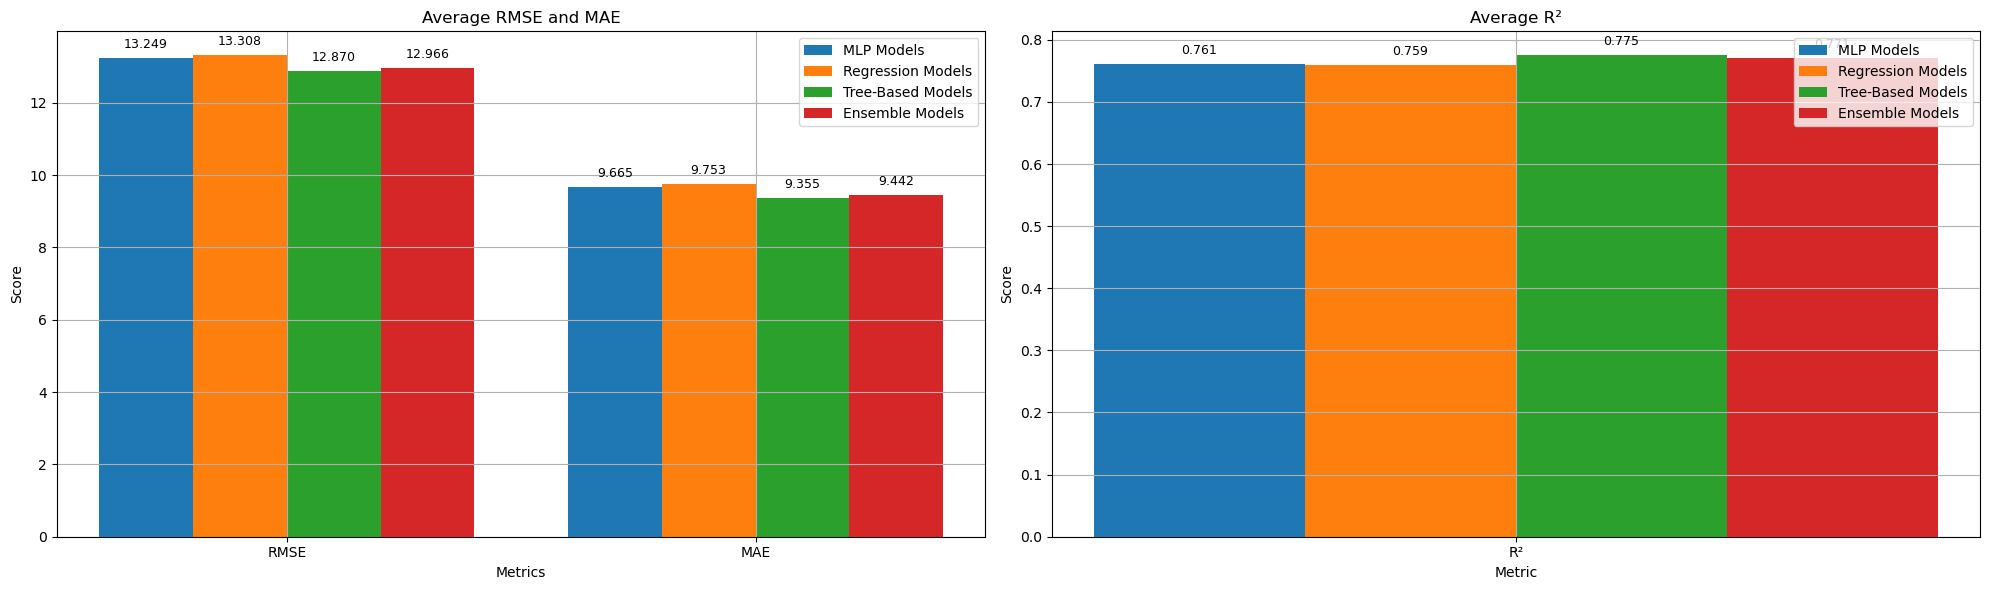

In [181]:
# Compute Averages

mlp_avg = mlp_models[['RMSE', 'MAE', 'R2']].mean()
regression_avg = regression_models[['RMSE', 'MAE', 'R2']].mean()
tree_based_avg = tree_models[['RMSE', 'MAE', 'R2']].mean()
ensemble_avg = ensemble_models[['RMSE', 'MAE', 'R2']].mean()  

# Prepare arrays
metrics = ['RMSE', 'MAE', 'R2']

mlp_vals = mlp_avg.values
regression_vals = regression_avg.values
tree_based_vals = tree_based_avg.values
ensemble_vals = ensemble_avg.values  

# Create side-by-side plots

x = np.arange(2)  # Only RMSE and MAE for first plot
width = 0.2  # Narrower bars because 4 groups now

fig, axes = plt.subplots(1, 2, figsize=(20,6))  # 1 row, 2 columns

# Left plot: RMSE and MAE
axes[0].bar(x - 1.5*width, mlp_vals[:2], width, label='MLP Models')
axes[0].bar(x - 0.5*width, regression_vals[:2], width, label='Regression Models')
axes[0].bar(x + 0.5*width, tree_based_vals[:2], width, label='Tree-Based Models')
axes[0].bar(x + 1.5*width, ensemble_vals[:2], width, label='Ensemble Models')  

axes[0].set_xlabel('Metrics')
axes[0].set_ylabel('Score')
axes[0].set_title('Average RMSE and MAE')
axes[0].set_xticks(x)
axes[0].set_xticklabels(['RMSE', 'MAE'])
axes[0].legend()
axes[0].grid(True)

for bar_group in bars:
    for bar in bar_group:
        height = bar.get_height()
        axes[0].annotate(f'{height:.3f}',  # 3 decimal places
                         xy=(bar.get_x() + bar.get_width() / 2, height),
                         xytext=(0, 5),
                         textcoords="offset points",
                         ha='center', va='bottom', fontsize=9)

# Right plot: R²
x_r2 = np.arange(1)  # Only 1 bar per group

axes[1].bar(x_r2 - 1.5*width, [mlp_vals[2]], width, label='MLP Models')
axes[1].bar(x_r2 - 0.5*width, [regression_vals[2]], width, label='Regression Models')
axes[1].bar(x_r2 + 0.5*width, [tree_based_vals[2]], width, label='Tree-Based Models')
axes[1].bar(x_r2 + 1.5*width, [ensemble_vals[2]], width, label='Ensemble Models')  

axes[1].set_xlabel('Metric')
axes[1].set_ylabel('Score')
axes[1].set_title('Average R²')
axes[1].set_xticks([0])
axes[1].set_xticklabels(['R²'])
axes[1].legend()
axes[1].grid(True)

for bar_group in bars_r2:
    for bar in bar_group:
        height = bar.get_height()
        axes[1].annotate(f'{height:.3f}',
                         xy=(bar.get_x() + bar.get_width() / 2, height),
                         xytext=(0, 5),
                         textcoords="offset points",
                         ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


# Box Plot 

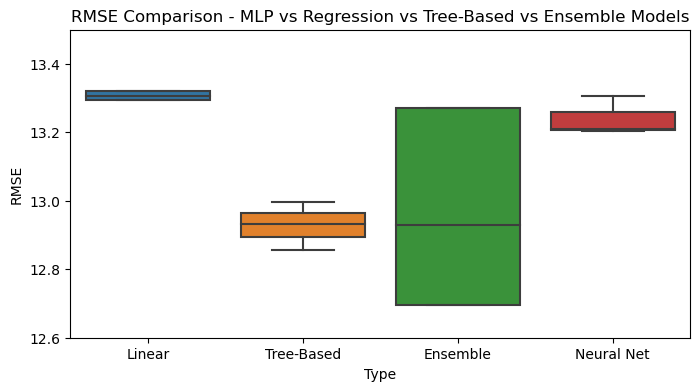

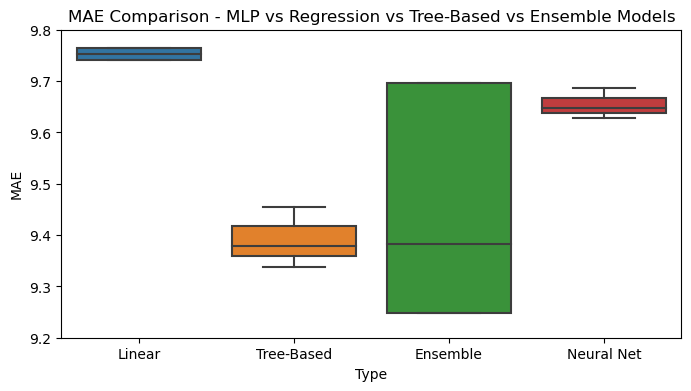

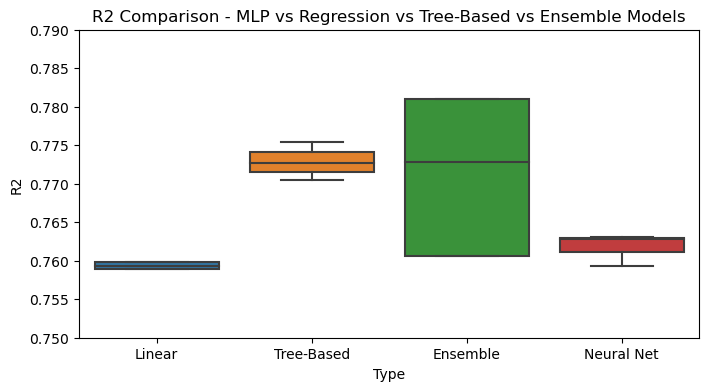

In [178]:
# Combine models into one dataframe for comparison 
comparison_df = pd.concat([regression_models[['Model', 'RMSE', 'MAE', 'R2', 'Type']],
                           tree_models[['Model', 'RMSE', 'MAE', 'R2', 'Type']]])

comparison_df = pd.concat([
    regression_models[['Model', 'RMSE', 'MAE', 'R2', 'Type']],
    tree_models[['Model', 'RMSE', 'MAE', 'R2', 'Type']],
    mlp_models[['Model', 'RMSE', 'MAE', 'R2', 'Type']],
    ensemble_models[['Model', 'RMSE', 'MAE', 'R2', 'Type']]
]) 

# Box plots
plt.figure(figsize=(8,4))
sns.boxplot(x='Type', y='RMSE', data=comparison_df)
plt.ylim(12.6, 13.5)  
plt.title('RMSE Comparison - MLP vs Regression vs Tree-Based vs Ensemble Models')
plt.show()

plt.figure(figsize=(8,4))
sns.boxplot(x='Type', y='MAE', data=comparison_df)
plt.ylim(9.2, 9.8)  
plt.title('MAE Comparison - MLP vs Regression vs Tree-Based vs Ensemble Models')
plt.show()

plt.figure(figsize=(8,4))
sns.boxplot(x='Type', y='R2', data=comparison_df)
plt.ylim(0.75, 0.79)  
plt.title('R2 Comparison - MLP vs Regression vs Tree-Based vs Ensemble Models')
plt.show()

# Violin Plots 

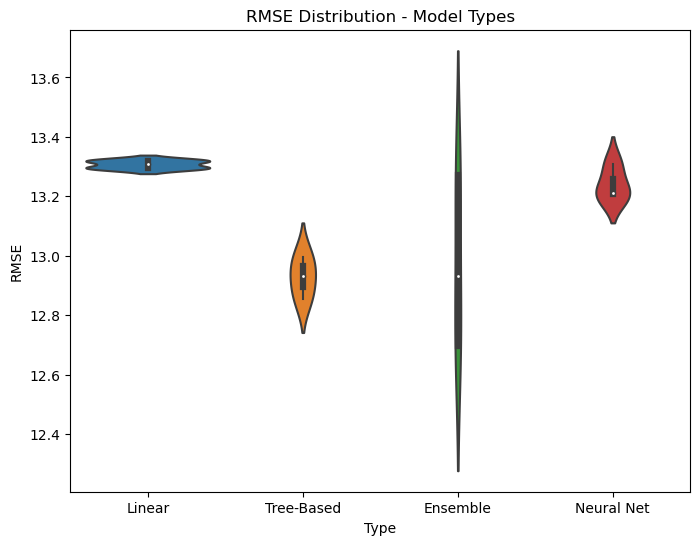

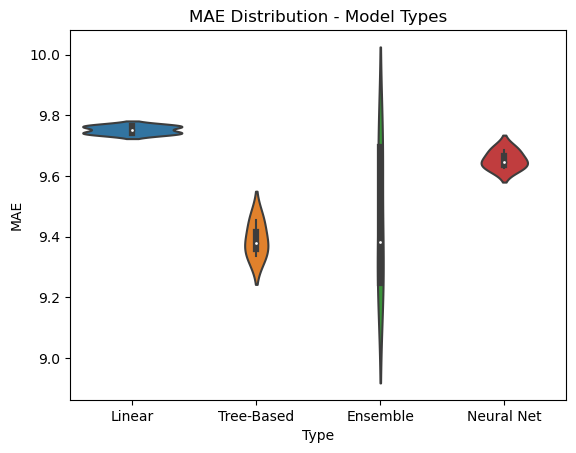

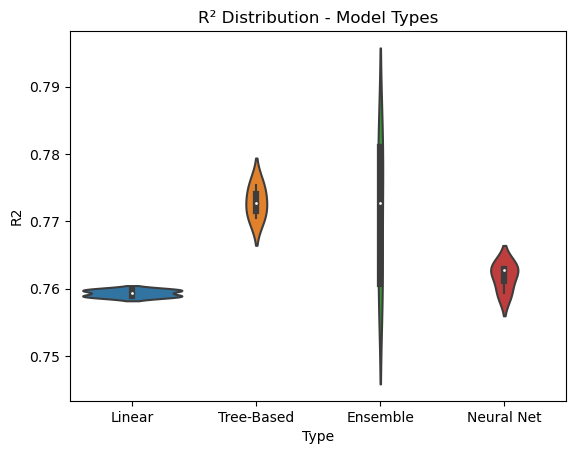

In [172]:
plt.figure(figsize=(8, 6))

sns.violinplot(x='Type', y='RMSE', data=comparison_df)
plt.title('RMSE Distribution - Model Types')
plt.show()

sns.violinplot(x='Type', y='MAE', data=comparison_df)
plt.title('MAE Distribution - Model Types')
plt.show()

sns.violinplot(x='Type', y='R2', data=comparison_df)
plt.title('R² Distribution - Model Types')
plt.show()

# Parallel Coordinates 

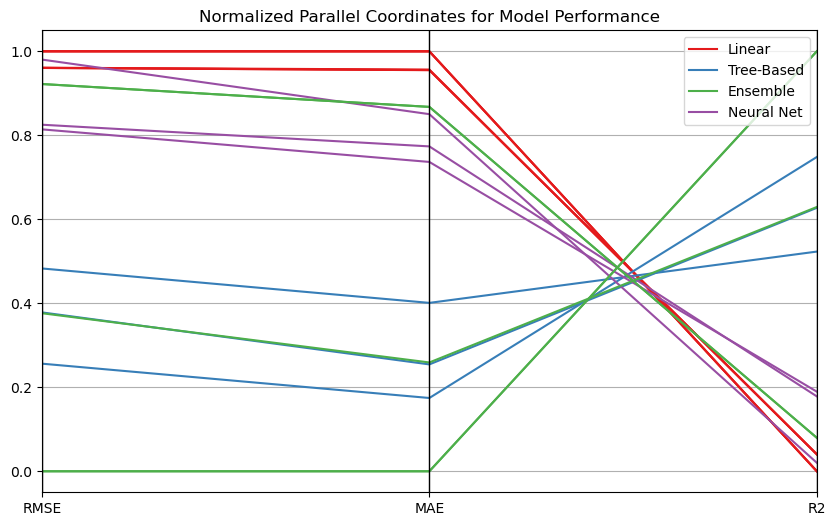

In [173]:
# Normalize RMSE, MAE, R2
metrics_to_normalize = ['RMSE', 'MAE', 'R2']

scaler = MinMaxScaler()

# Only scale the metrics, not the Model/Type columns
comparison_df_scaled = comparison_df.copy()
comparison_df_scaled[metrics_to_normalize] = scaler.fit_transform(comparison_df[metrics_to_normalize])

plt.figure(figsize=(10,6))
parallel_coordinates(comparison_df_scaled, 'Type', cols=metrics_to_normalize, color=plt.cm.Set1.colors)
plt.title('Normalized Parallel Coordinates for Model Performance')
plt.grid(True)
plt.show()


# Bar Plot For All Models

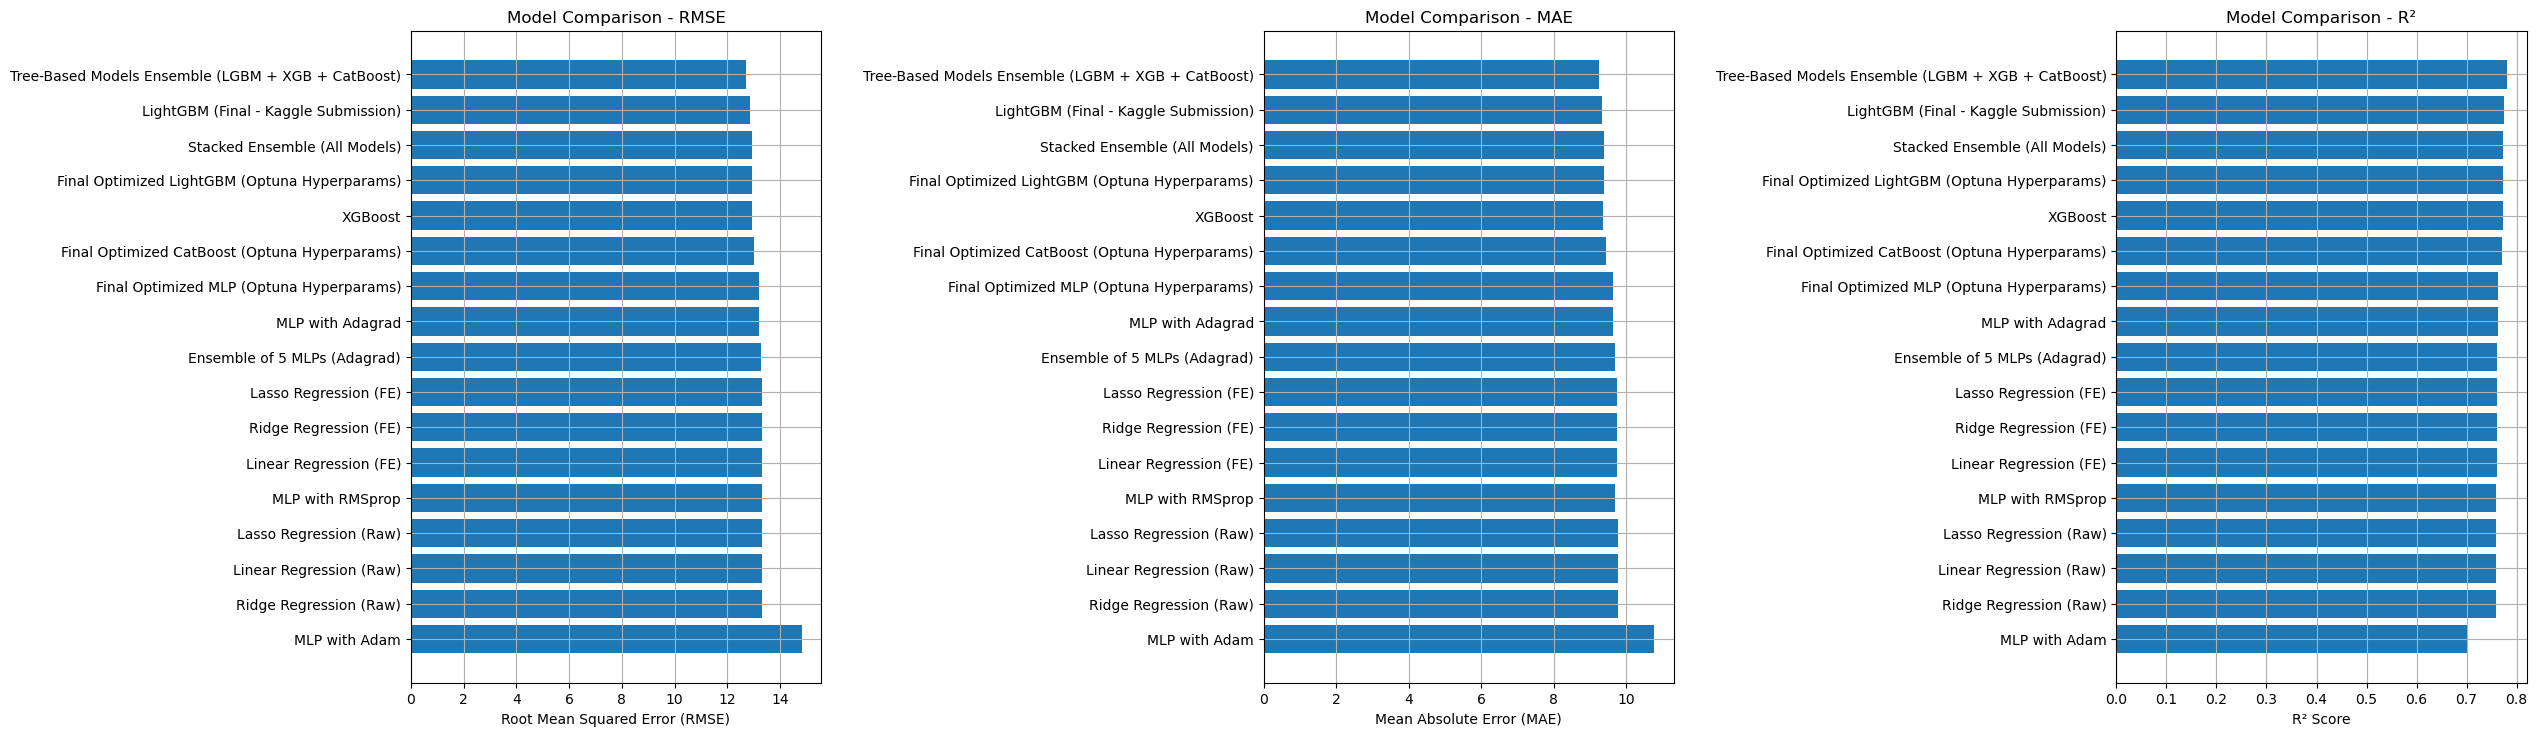

In [185]:
# Remove rows with NaN values
results_df_filtered = results_df.dropna(subset=['RMSE', 'MAE', 'R2']) #dropped MLP with SGD as it looks like 0 on plot

# Sort results by R² 
results_df_sorted = results_df_filtered.sort_values(by='R2').reset_index(drop=True)

fig, axes = plt.subplots(1, 3, figsize=(26, 8))

# RMSE Plot
axes[0].barh(results_df_sorted['Model'], results_df_sorted['RMSE'])
axes[0].set_xlabel('Root Mean Squared Error (RMSE)')
axes[0].set_title('Model Comparison - RMSE')
axes[0].grid(True)

# MAE Plot
axes[1].barh(results_df_sorted['Model'], results_df_sorted['MAE'])
axes[1].set_xlabel('Mean Absolute Error (MAE)')
axes[1].set_title('Model Comparison - MAE')
axes[1].grid(True)

# R² Plot
axes[2].barh(results_df_sorted['Model'], results_df_sorted['R2'])
axes[2].set_xlabel('R² Score')
axes[2].set_title('Model Comparison - R²')
axes[2].grid(True)

plt.tight_layout(pad=3.0)
plt.show()